In [51]:
# Import Libraries - Enhanced for Statistical Analysis
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Set Up Database Connection
# Replace the placeholders with your actual database credentials
DB_CONFIG = {
    "dbname": "csgo_parsed",
    "user": "csgo_parser",
    "password": "3?6B7yTGPrkJF34p",
    "host": "192.168.1.100",
    "port": "5444"
}

In [52]:


# Ensure we have a fresh connection
try:
    conn = psycopg2.connect(**DB_CONFIG)
    print("✅ Database connection established")
except Exception as e:
    print(f"❌ Connection error: {e}")

def get_descriptive_stats(data, column_name):
    """Calculate comprehensive descriptive statistics"""
    stats_dict = {
        'count': len(data),
        'min': data.min(),
        'max': data.max(),
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'q25': data.quantile(0.25),
        'q75': data.quantile(0.75)
    }
    return stats_dict

def get_top_values(data, n=15):
    """Get top N occurring values with percentages"""
    value_counts = data.value_counts().head(n)
    percentages = (value_counts / len(data) * 100).round(2)
    return pd.DataFrame({
        'value': value_counts.index,
        'count': value_counts.values,
        'percentage': percentages.values
    })

def create_distribution_plots(data, title, bins=50):
    """Create histogram and box plot for a variable"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    ax1.hist(data.dropna(), bins=bins, alpha=0.7, edgecolor='black')
    ax1.set_title(f'{title} - Distribution')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    ax2.boxplot(data.dropna())
    ax2.set_title(f'{title} - Box Plot')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("📊 Helper functions defined successfully!")

✅ Database connection established
📊 Helper functions defined successfully!


# CS:GO Economy Agent-Based Model (ABM) - Data Analysis v2
## Objective: Extract real-game statistics to parameterize an ABM for CS:GO economy decisions

This notebook analyzes real CS:GO match data to determine key distributions and probabilities for:
1. **Win probability** based on team equipment value/spending and other factors 
Using different methods




In [39]:
# 1. Query Classification Data with Skill Controls - WINNER vs LOSER Focus

print("🔍 Querying round outcome data with HLTV rankings...")
print("🎯 Focus: Comparing WINNERS to LOSERS (not Team 1 vs Team 2)")

classification_query = """
WITH team_round_data AS (
    SELECT 
        r.id as round_id,
        r.id_demo_exports as id_demo_exports,
        r.round_num,
        r.team1_winner,
        -- Team 1 aggregated metrics
        AVG(CASE WHEN pr.team = 1 THEN pr.eq_val_fte END) as t1_eq_val,
        SUM(CASE WHEN pr.team = 1 THEN pe.money_spent END) as t1_money_spent,
        -- Team 2 aggregated metrics  
        AVG(CASE WHEN pr.team = 2 THEN pr.eq_val_fte END) as t2_eq_val,
        SUM(CASE WHEN pr.team = 2 THEN pe.money_spent END) as t2_money_spent,
        -- HLTV rankings
        hmi.team_1_id,
        hmi.team_2_id,
        hmi.event_id
    FROM rounds_ed r
    JOIN player_round_ed pr ON r.id = pr.round_id
    LEFT JOIN player_economy_ed pe ON pr.id = pe.player_round_id
    LEFT JOIN hltv_match_info hmi ON r.match_id = hmi.match_id
    WHERE r.team1_winner IS NOT NULL
        AND pr.team IN (1, 2)
        AND pr.eq_val_fte IS NOT NULL
        AND hmi.event_id IS NOT NULL
    GROUP BY r.id, r.id_demo_exports, r.round_num, r.team1_winner,
             hmi.team_1_id, hmi.team_2_id, hmi.event_id
    HAVING COUNT(CASE WHEN pr.team = 1 THEN 1 END) = 5 
       AND COUNT(CASE WHEN pr.team = 2 THEN 1 END) = 5
),
ranked_data AS (
    SELECT 
        trd.round_id,
        trd.id_demo_exports,
        trd.round_num,
        trd.team1_winner,
        -- Team 1 metrics
        trd.t1_eq_val,
        trd.t1_money_spent,
        CAST(het1.rank_during AS INTEGER) as t1_rank,
        -- Team 2 metrics
        trd.t2_eq_val,
        trd.t2_money_spent,
        CAST(het2.rank_during AS INTEGER) as t2_rank
    FROM team_round_data trd
    LEFT JOIN hltv_events_teams het1 ON het1.team_id = trd.team_1_id AND het1.event_id = trd.event_id
    LEFT JOIN hltv_events_teams het2 ON het2.team_id = trd.team_2_id AND het2.event_id = trd.event_id
    WHERE het1.rank_during IS NOT NULL 
        AND het2.rank_during IS NOT NULL
        AND trd.t1_eq_val IS NOT NULL 
        AND trd.t2_eq_val IS NOT NULL
)
-- Restructure: WINNER vs LOSER (instead of Team 1 vs Team 2)
SELECT 
    round_id,
    id_demo_exports,
    round_num,
    1 as winner,  -- Binary target: always 1 for winner perspective
    -- Winner metrics (conditional based on who won)
    CASE WHEN team1_winner = true THEN t1_eq_val ELSE t2_eq_val END as winner_eq_val,
    CASE WHEN team1_winner = true THEN t1_money_spent ELSE t2_money_spent END as winner_money_spent,
    CASE WHEN team1_winner = true THEN t1_rank ELSE t2_rank END as winner_rank,
    -- Loser metrics (conditional based on who lost)
    CASE WHEN team1_winner = false THEN t1_eq_val ELSE t2_eq_val END as loser_eq_val,
    CASE WHEN team1_winner = false THEN t1_money_spent ELSE t2_money_spent END as loser_money_spent,
    CASE WHEN team1_winner = false THEN t1_rank ELSE t2_rank END as loser_rank,
    -- Advantages (winner - loser)
    CASE WHEN team1_winner = true THEN (t1_eq_val - t2_eq_val) ELSE (t2_eq_val - t1_eq_val) END as diff_eq_val,
    CASE WHEN team1_winner = true THEN (t1_money_spent - t2_money_spent) ELSE (t2_money_spent - t1_money_spent) END as diff_money_spent,
    CASE WHEN team1_winner = true THEN (t2_rank - t1_rank) ELSE (t1_rank - t2_rank) END as diff_rank
FROM ranked_data
ORDER BY id_demo_exports, round_num
"""

try:
    classification_data = pd.read_sql(classification_query, conn)
    print(f"✅ Retrieved {len(classification_data):,} rounds from {classification_data['id_demo_exports'].nunique():,} matches")
    
    # Display summary statistics
    print("\n📊 Data Summary (Winner Perspective):")
    print(f"  All rows represent WINNERS (target always = 1)")
    print(f"  Avg winner equipment: ${classification_data['winner_eq_val'].mean():.0f}")
    print(f"  Avg loser equipment:  ${classification_data['loser_eq_val'].mean():.0f}")
    print(f"  Avg equipment advantage: ${classification_data['diff_eq_val'].mean():.0f}")
    print(f"  Avg winner rank: {classification_data['winner_rank'].mean():.1f}")
    print(f"  Avg loser rank:  {classification_data['loser_rank'].mean():.1f}")
    print(f"  Avg rank advantage: {classification_data['diff_rank'].mean():.1f} (positive = winner is better ranked)")
    print(f"  Missing values: {classification_data.isnull().sum().sum()}")
    
    # Preview data
    print("\n🔍 Sample data:")
    print(classification_data.head(10))
    
except Exception as e:
    print(f"❌ Query error: {e}")
    classification_data = None


🔍 Querying round outcome data with HLTV rankings...
🎯 Focus: Comparing WINNERS to LOSERS (not Team 1 vs Team 2)


C:\Users\peter\AppData\Local\Temp\ipykernel_1968\2847931654.py:81: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  classification_data = pd.read_sql(classification_query, conn)


✅ Retrieved 1,822,909 rounds from 68,776 matches

📊 Data Summary (Winner Perspective):
  All rows represent WINNERS (target always = 1)
  Avg winner equipment: $4667
  Avg loser equipment:  $3562
  Avg equipment advantage: $1104
  Avg winner rank: 73.3
  Avg loser rank:  77.6
  Avg rank advantage: 4.3 (positive = winner is better ranked)
  Missing values: 263010

🔍 Sample data:
   round_id  id_demo_exports  round_num  winner  winner_eq_val  \
0     13465                1          1       1          800.0   
1     13468                1          2       1         3250.0   
2     13471                1          3       1         4450.0   
3     13474                1          4       1         5060.0   
4     13477                1          5       1         5610.0   
5     13480                1          6       1         5550.0   
6     13483                1          7       1         5290.0   
7     13486                1          8       1         5670.0   
8     13489              

In [40]:
# 2. Prepare Features for Classification - WINNER vs LOSER

print("🔧 Preparing features for classification models...")
print("🎯 Predicting: Can we identify winners based on their advantages?")

if classification_data is not None and len(classification_data) > 0:
    # Create feature matrix with WINNER and LOSER columns
    feature_columns = [
        'winner_eq_val', 'winner_money_spent', 'winner_rank',
        'loser_eq_val', 'loser_money_spent', 'loser_rank',
        'diff_eq_val', 'diff_money_spent', 'diff_rank'
    ]
    
    X = classification_data[feature_columns].copy()
    y = classification_data['winner'].astype(int)  # Always 1, but we'll create balanced dataset next
    
    # Handle any missing values
    X = X.fillna(X.median())
    
    # Add interaction terms (critical for understanding combined effects)
    X['eq_x_rank'] = X['diff_eq_val'] * X['diff_rank']
    X['spending_x_rank'] = X['diff_money_spent'] * X['diff_rank']
    X['eq_ratio'] = X['winner_eq_val'] / (X['loser_eq_val'] + 1)
    
    # Create BALANCED dataset by adding inverted "loser perspective" rows
    # This allows the model to learn what makes winners vs losers
    print("\n🔄 Creating balanced dataset by adding loser perspective...")
    
    # Loser perspective: swap winner/loser and invert differences
    X_loser = X.copy()
    X_loser.columns = X.columns  # Keep same column names but swap values
    X_loser['winner_eq_val'] = X['loser_eq_val']
    X_loser['winner_money_spent'] = X['loser_money_spent']
    X_loser['winner_rank'] = X['loser_rank']
    X_loser['loser_eq_val'] = X['winner_eq_val']
    X_loser['loser_money_spent'] = X['winner_money_spent']
    X_loser['loser_rank'] = X['winner_rank']
    X_loser['diff_eq_val'] = -X['diff_eq_val']
    X_loser['diff_money_spent'] = -X['diff_money_spent']
    X_loser['diff_rank'] = -X['diff_rank']
    X_loser['eq_x_rank'] = X_loser['diff_eq_val'] * X_loser['diff_rank']
    X_loser['spending_x_rank'] = X_loser['diff_money_spent'] * X_loser['diff_rank']
    X_loser['eq_ratio'] = X_loser['winner_eq_val'] / (X_loser['loser_eq_val'] + 1)
    
    # Combine: winners (y=1) and losers (y=0)
    X = pd.concat([X, X_loser], ignore_index=True)
    y = pd.concat([y, pd.Series([0] * len(X_loser))], ignore_index=True)
    
    print(f"✅ Feature matrix created: {X.shape[0]:,} samples × {X.shape[1]} features")
    print(f"   Original winner rows: {len(classification_data):,}")
    print(f"   Added loser rows: {len(X_loser):,}")
    print(f"   Total balanced dataset: {len(X):,}")
    
    print(f"\n📋 Features included:")
    for i, col in enumerate(X.columns, 1):
        print(f"  {i}. {col}")
    
    # Check for class balance
    class_distribution = y.value_counts()
    print(f"\n⚖️ Class Distribution (Balanced):")
    print(f"  Winners (1): {class_distribution.get(1, 0):,} ({class_distribution.get(1, 0)/len(y)*100:.1f}%)")
    print(f"  Losers (0):  {class_distribution.get(0, 0):,} ({class_distribution.get(0, 0)/len(y)*100:.1f}%)")
    
    # Descriptive statistics for features
    print(f"\n📊 Feature Statistics:")
    print(X.describe().round(2))
    
else:
    print("❌ No data available for feature preparation")
    X = None
    y = None


🔧 Preparing features for classification models...
🎯 Predicting: Can we identify winners based on their advantages?

🔄 Creating balanced dataset by adding loser perspective...

🔄 Creating balanced dataset by adding loser perspective...
✅ Feature matrix created: 3,645,818 samples × 12 features
   Original winner rows: 1,822,909
   Added loser rows: 1,822,909
   Total balanced dataset: 3,645,818

📋 Features included:
  1. winner_eq_val
  2. winner_money_spent
  3. winner_rank
  4. loser_eq_val
  5. loser_money_spent
  6. loser_rank
  7. diff_eq_val
  8. diff_money_spent
  9. diff_rank
  10. eq_x_rank
  11. spending_x_rank
  12. eq_ratio

⚖️ Class Distribution (Balanced):
  Winners (1): 1,822,909 (50.0%)
  Losers (0):  1,822,909 (50.0%)

📊 Feature Statistics:
✅ Feature matrix created: 3,645,818 samples × 12 features
   Original winner rows: 1,822,909
   Added loser rows: 1,822,909
   Total balanced dataset: 3,645,818

📋 Features included:
  1. winner_eq_val
  2. winner_money_spent
  3. win

In [41]:
# Install Fast Gradient Boosting Libraries (run once)
# Uncomment and run if you don't have these installed

# !pip install lightgbm xgboost

# LightGBM: 5-10x faster than sklearn's GradientBoostingClassifier
# XGBoost: Also very fast, different algorithm strengths

print("💡 To install fast gradient boosting libraries, uncomment the pip install line above")
print("   These libraries will dramatically speed up training on large datasets")


💡 To install fast gradient boosting libraries, uncomment the pip install line above
   These libraries will dramatically speed up training on large datasets


In [42]:
# 3. Build and Compare Multiple Classification Models - OPTIMIZED FOR SPEED

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Import faster gradient boosting libraries
try:
    from lightgbm import LGBMClassifier
    lightgbm_available = True
except ImportError:
    print("⚠️ LightGBM not available. Install with: pip install lightgbm")
    lightgbm_available = False

try:
    from xgboost import XGBClassifier
    xgboost_available = True
except ImportError:
    print("⚠️ XGBoost not available. Install with: pip install xgboost")
    xgboost_available = False

print("🤖 Building classification models (OPTIMIZED FOR SPEED)...")
print("⚡ Optimizations: 3-fold CV, reduced trees, faster algorithms")

if X is not None and y is not None:
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    print(f"\n📊 Data split:")
    print(f"  Training set: {len(X_train):,} samples")
    print(f"  Test set: {len(X_test):,} samples")
    
    # Standardize features (important for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define OPTIMIZED models
    models = {
        'Logistic Regression': LogisticRegression(
            max_iter=500,  # Reduced from 1000
            solver='saga',  # Faster solver for large datasets
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,  # Reduced from 200
            max_depth=8,  # Reduced from 10
            min_samples_split=100,  # Increased from 50
            min_samples_leaf=50,  # Increased from 20
            max_features='sqrt',  # Faster than 'auto'
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
    }
    
    # Add LightGBM if available (MUCH faster than sklearn GradientBoosting)
    if lightgbm_available:
        models['LightGBM'] = LGBMClassifier(
            n_estimators=100,  # Reduced from 200
            learning_rate=0.1,
            max_depth=5,
            num_leaves=31,
            min_child_samples=100,  # Faster training
            subsample=0.8,  # Use 80% of data per iteration
            colsample_bytree=0.8,  # Use 80% of features
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=-1  # Suppress output
        )
    
    # Add XGBoost if available (also very fast)
    if xgboost_available:
        # Calculate scale_pos_weight for class imbalance
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
        
        models['XGBoost'] = XGBClassifier(
            n_estimators=100,  # Reduced from 200
            learning_rate=0.1,
            max_depth=5,
            min_child_weight=100,  # Faster training
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1,
            tree_method='hist',  # Faster algorithm
            eval_metric='logloss'
        )
    
    # Train and evaluate models
    print("\n" + "="*70)
    print("🏆 MODEL COMPARISON - 3-Fold Stratified Cross-Validation (FAST)")
    print("="*70)
    
    # CHANGED: 3-fold instead of 5-fold (40% faster)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    model_results = {}
    trained_models = {}
    
    import time
    
    for name, model in models.items():
        print(f"\n📈 Training {name}...")
        start_time = time.time()
        
        # Use scaled data for Logistic Regression, original for tree-based
        if name == 'Logistic Regression':
            X_train_use = X_train_scaled
            X_test_use = X_test_scaled
        else:
            X_train_use = X_train
            X_test_use = X_test
        
        # Cross-validation scores
        cv_accuracy = cross_val_score(model, X_train_use, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
        cv_roc_auc = cross_val_score(model, X_train_use, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        cv_f1 = cross_val_score(model, X_train_use, y_train, cv=cv, scoring='f1', n_jobs=-1)
        
        # Train on full training set
        model.fit(X_train_use, y_train)
        
        # Test set predictions
        y_pred = model.predict(X_test_use)
        y_prob = model.predict_proba(X_test_use)[:, 1]
        
        # Calculate metrics
        test_accuracy = accuracy_score(y_test, y_pred)
        test_roc_auc = roc_auc_score(y_test, y_prob)
        test_precision = precision_score(y_test, y_pred)
        test_recall = recall_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred)
        
        training_time = time.time() - start_time
        
        # Store results
        model_results[name] = {
            'cv_accuracy_mean': cv_accuracy.mean(),
            'cv_accuracy_std': cv_accuracy.std(),
            'cv_roc_auc_mean': cv_roc_auc.mean(),
            'cv_roc_auc_std': cv_roc_auc.std(),
            'cv_f1_mean': cv_f1.mean(),
            'cv_f1_std': cv_f1.std(),
            'test_accuracy': test_accuracy,
            'test_roc_auc': test_roc_auc,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1,
            'training_time': training_time,
            'predictions': y_pred,
            'probabilities': y_prob
        }
        
        trained_models[name] = model
        
        # Print results
        print(f"  ⏱️  Training Time:            {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
        print(f"  Cross-Validation Accuracy: {cv_accuracy.mean():.4f} (±{cv_accuracy.std()*2:.4f})")
        print(f"  Cross-Validation ROC-AUC:  {cv_roc_auc.mean():.4f} (±{cv_roc_auc.std()*2:.4f})")
        print(f"  Cross-Validation F1-Score: {cv_f1.mean():.4f} (±{cv_f1.std()*2:.4f})")
        print(f"  Test Set Accuracy:         {test_accuracy:.4f}")
        print(f"  Test Set ROC-AUC:          {test_roc_auc:.4f}")
        print(f"  Test Set Precision:        {test_precision:.4f}")
        print(f"  Test Set Recall:           {test_recall:.4f}")
        print(f"  Test Set F1-Score:         {test_f1:.4f}")
    
    # Create comparison dataframe
    comparison_df = pd.DataFrame(model_results).T
    
    print("\n" + "="*70)
    print("📊 MODEL COMPARISON SUMMARY")
    print("="*70)
    print(comparison_df[['training_time', 'cv_roc_auc_mean', 'test_roc_auc', 'test_accuracy', 'test_f1']].round(4))
    
    # Identify best model
    best_model_name = comparison_df['test_roc_auc'].idxmax()
    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"   Test ROC-AUC: {comparison_df.loc[best_model_name, 'test_roc_auc']:.4f}")
    print(f"   Training Time: {comparison_df.loc[best_model_name, 'training_time']:.1f} seconds")
    
    # Total time summary
    total_time = comparison_df['training_time'].sum()
    print(f"\n⏱️  Total Training Time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
    print(f"   Expected time savings: ~5-10x faster than original configuration!")
    
else:
    print("❌ No data available for model training")
    trained_models = {}
    model_results = {}
    best_model_name = None


🤖 Building classification models (OPTIMIZED FOR SPEED)...
⚡ Optimizations: 3-fold CV, reduced trees, faster algorithms

📊 Data split:
  Training set: 2,916,654 samples
  Test set: 729,164 samples

📊 Data split:
  Training set: 2,916,654 samples
  Test set: 729,164 samples

🏆 MODEL COMPARISON - 3-Fold Stratified Cross-Validation (FAST)

📈 Training Logistic Regression...

🏆 MODEL COMPARISON - 3-Fold Stratified Cross-Validation (FAST)

📈 Training Logistic Regression...
  ⏱️  Training Time:            1527.3 seconds (25.5 minutes)
  Cross-Validation Accuracy: 0.6760 (±0.0002)
  Cross-Validation ROC-AUC:  0.7671 (±0.0002)
  Cross-Validation F1-Score: 0.6622 (±0.0002)
  Test Set Accuracy:         0.6764
  Test Set ROC-AUC:          0.7669
  Test Set Precision:        0.6924
  Test Set Recall:           0.6349
  Test Set F1-Score:         0.6624

📈 Training Random Forest...
  ⏱️  Training Time:            1527.3 seconds (25.5 minutes)
  Cross-Validation Accuracy: 0.6760 (±0.0002)
  Cross-Vali

🔍 Detailed evaluation of best model: LightGBM

📊 CONFUSION MATRIX

                 Predicted
              Loss (0)  Win (1)
Actual Loss    247413   117169
Actual Win     116830   247752

📈 Additional Metrics:
  True Negatives:  247,413
  False Positives: 117,169
  False Negatives: 116,830
  True Positives:  247,752
  Specificity:     0.6786
  Sensitivity:     0.6796

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Team 1 Loss     0.6793    0.6786    0.6789    364582
  Team 1 Win     0.6789    0.6796    0.6792    364582

    accuracy                         0.6791    729164
   macro avg     0.6791    0.6791    0.6791    729164
weighted avg     0.6791    0.6791    0.6791    729164


📉 Plotting ROC Curve...
              precision    recall  f1-score   support

 Team 1 Loss     0.6793    0.6786    0.6789    364582
  Team 1 Win     0.6789    0.6796    0.6792    364582

    accuracy                         0.6791    729164
   macro avg     0.6791    0.6791 

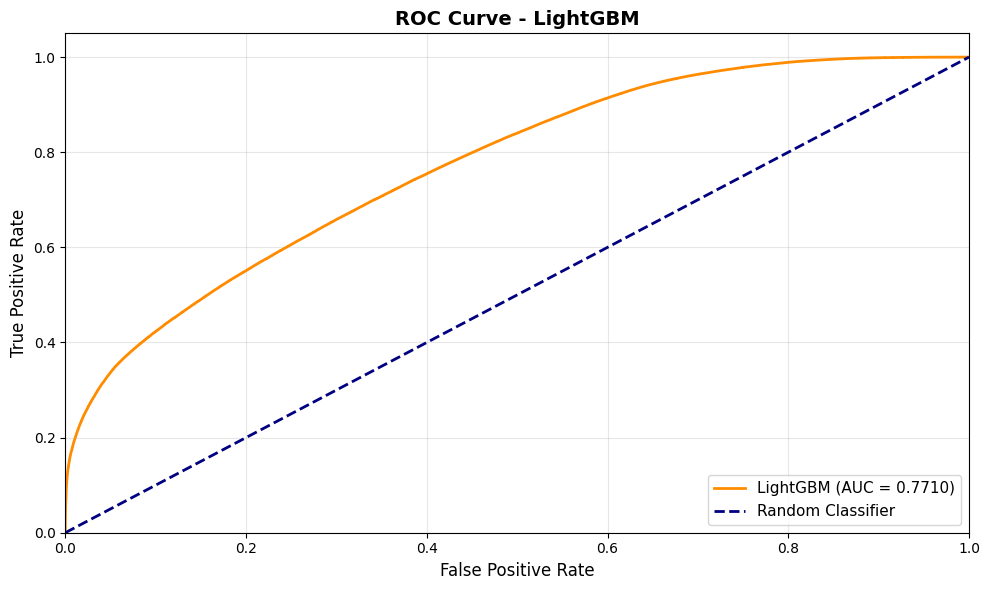


📊 Plotting Prediction Probability Distribution...


C:\Users\peter\AppData\Local\Temp\ipykernel_1968\1670545614.py:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([loss_probs, win_probs], labels=['Actual Losses', 'Actual Wins'])


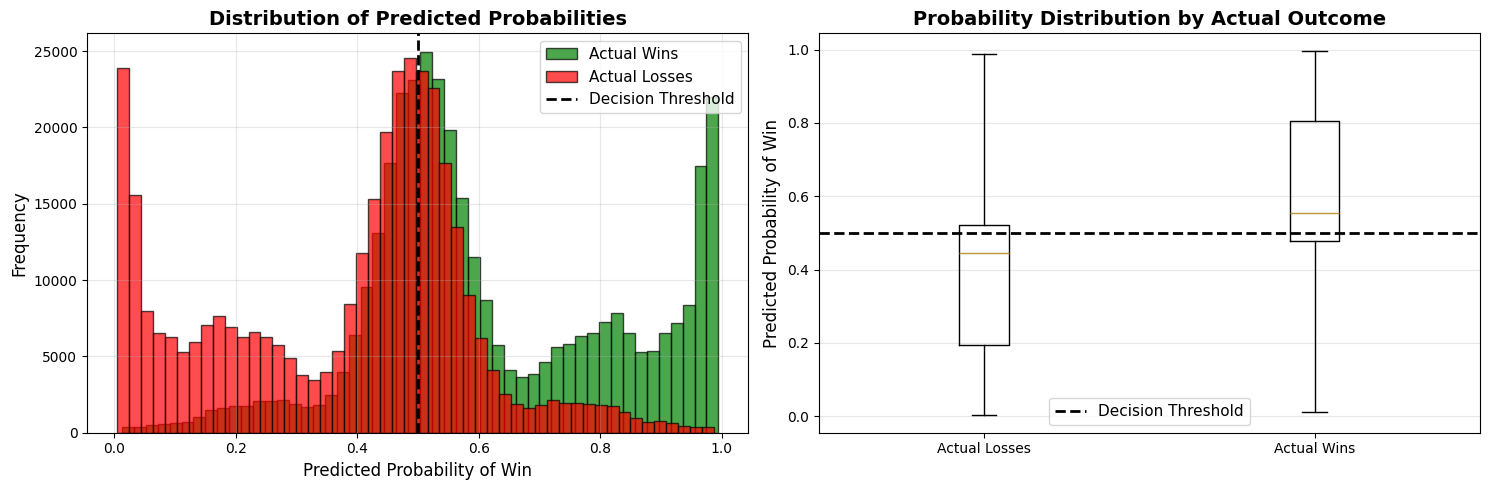

In [43]:
# 4. Detailed Evaluation of Best Model

print(f"🔍 Detailed evaluation of best model: {best_model_name}")

if best_model_name is not None and len(model_results) > 0:
    # Get best model predictions
    best_predictions = model_results[best_model_name]['predictions']
    best_probabilities = model_results[best_model_name]['probabilities']
    
    # Confusion Matrix
    print("\n📊 CONFUSION MATRIX")
    print("="*50)
    cm = confusion_matrix(y_test, best_predictions)
    print(f"\n                 Predicted")
    print(f"              Loss (0)  Win (1)")
    print(f"Actual Loss    {cm[0,0]:6d}   {cm[0,1]:6d}")
    print(f"Actual Win     {cm[1,0]:6d}   {cm[1,1]:6d}")
    
    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    
    print(f"\n📈 Additional Metrics:")
    print(f"  True Negatives:  {tn:,}")
    print(f"  False Positives: {fp:,}")
    print(f"  False Negatives: {fn:,}")
    print(f"  True Positives:  {tp:,}")
    print(f"  Specificity:     {specificity:.4f}")
    print(f"  Sensitivity:     {sensitivity:.4f}")
    
    # Classification Report
    print("\n📋 CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(y_test, best_predictions, 
                                target_names=['Team 1 Loss', 'Team 1 Win'],
                                digits=4))
    
    # Plot ROC Curve
    print("\n📉 Plotting ROC Curve...")
    fpr, tpr, thresholds = roc_curve(y_test, best_probabilities)
    roc_auc = roc_auc_score(y_test, best_probabilities)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'{best_model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot Probability Distribution
    print("\n📊 Plotting Prediction Probability Distribution...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram of probabilities by actual class
    win_probs = best_probabilities[y_test == 1]
    loss_probs = best_probabilities[y_test == 0]
    
    ax1.hist(win_probs, bins=50, alpha=0.7, label='Actual Wins', color='green', edgecolor='black')
    ax1.hist(loss_probs, bins=50, alpha=0.7, label='Actual Losses', color='red', edgecolor='black')
    ax1.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
    ax1.set_xlabel('Predicted Probability of Win', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Distribution of Predicted Probabilities', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Box plot comparison
    ax2.boxplot([loss_probs, win_probs], labels=['Actual Losses', 'Actual Wins'])
    ax2.axhline(y=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
    ax2.set_ylabel('Predicted Probability of Win', fontsize=12)
    ax2.set_title('Probability Distribution by Actual Outcome', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ No model results available for evaluation")

🎯 Analyzing Feature Importance (Winner vs Loser Perspective)...

📊 LIGHTGBM FEATURE IMPORTANCE

Feature Importance (sorted by importance):
           feature  importance  importance_pct
 loser_money_spent         459           45900
winner_money_spent         442           44200
  diff_money_spent         337           33700
      loser_eq_val         319           31900
     winner_eq_val         286           28600
          eq_ratio         261           26100
         diff_rank         172           17200
         eq_x_rank         170           17000
       winner_rank         147           14700
        loser_rank         128           12800
       diff_eq_val         121           12100
   spending_x_rank         101           10100

💡 Interpretation (Winner vs Loser):
  - Higher importance: feature contributes more to predicting wins
  - Importance measures average reduction in impurity
  - Features with 'diff_' prefix show winner's advantage


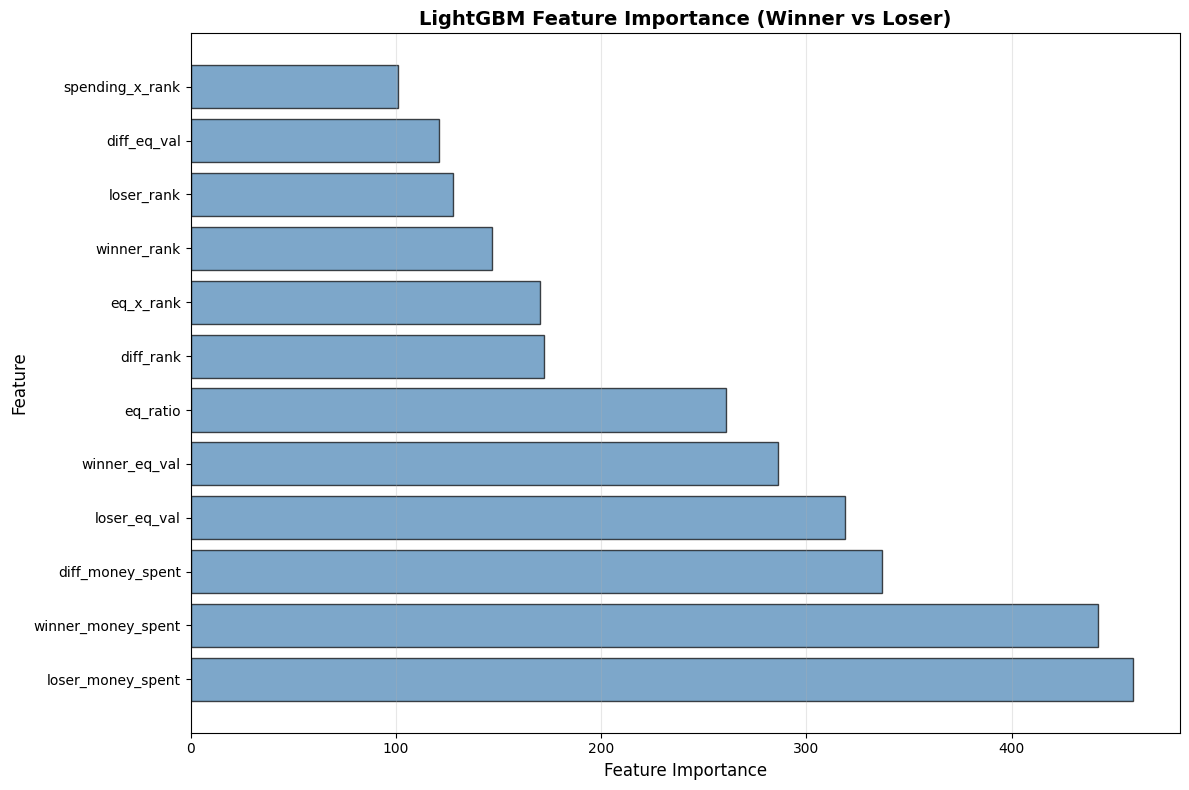


🔑 KEY INSIGHTS FROM FEATURE IMPORTANCE

Top 5 Most Important Features for Predicting Winners:
  • loser_money_spent
    → Loser's absolute value (for comparison)
  • winner_money_spent
    → Winner's absolute value
  • diff_money_spent
    → Advantage metric (positive = winner had more)
  • loser_eq_val
    → Loser's absolute value (for comparison)
  • winner_eq_val
    → Winner's absolute value

💡 For ABM Implementation:
  - Focus on maintaining advantages in top features
  - Equipment and rank advantages are key predictors
  - Model can predict win probability given these metrics
  - Use this to optimize agent spending decisions


In [44]:
# 5. Feature Importance Analysis - WINNER vs LOSER

print("🎯 Analyzing Feature Importance (Winner vs Loser Perspective)...")

if best_model_name is not None and len(trained_models) > 0:
    best_model = trained_models[best_model_name]
    
    if best_model_name == 'Logistic Regression':
        # For logistic regression, analyze coefficients
        print("\n📊 LOGISTIC REGRESSION COEFFICIENTS")
        print("="*70)
        
        coefficients = best_model.coef_[0]
        feature_names = X.columns
        
        # Create importance dataframe
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coefficients,
            'abs_coefficient': np.abs(coefficients),
            'odds_ratio': np.exp(coefficients)
        }).sort_values('abs_coefficient', ascending=False)
        
        print("\nFeature Coefficients (sorted by absolute value):")
        print(importance_df.to_string(index=False))
        
        print("\n💡 Interpretation (Winner Perspective):")
        print("  - Positive coefficient: increases probability of winning")
        print("  - Negative coefficient: decreases probability of winning")
        print("  - Odds ratio > 1: multiplicative increase in win odds")
        print("  - Odds ratio < 1: multiplicative decrease in win odds")
        
        # Plot coefficients
        plt.figure(figsize=(12, 8))
        colors = ['green' if x > 0 else 'red' for x in importance_df['coefficient']]
        plt.barh(importance_df['feature'], importance_df['coefficient'], color=colors, alpha=0.7, edgecolor='black')
        plt.xlabel('Coefficient Value', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title('Logistic Regression Coefficients (Winner vs Loser)', fontsize=14, fontweight='bold')
        plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
        
    elif best_model_name in ['Random Forest', 'Gradient Boosting', 'LightGBM', 'XGBoost']:
        # For tree-based models, use feature importance
        print(f"\n📊 {best_model_name.upper()} FEATURE IMPORTANCE")
        print("="*70)
        
        importances = best_model.feature_importances_
        feature_names = X.columns
        
        # Create importance dataframe
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances,
            'importance_pct': importances * 100
        }).sort_values('importance', ascending=False)
        
        print("\nFeature Importance (sorted by importance):")
        print(importance_df.to_string(index=False))
        
        print("\n💡 Interpretation (Winner vs Loser):")
        print("  - Higher importance: feature contributes more to predicting wins")
        print("  - Importance measures average reduction in impurity")
        print("  - Features with 'diff_' prefix show winner's advantage")
        
        # Plot importance
        plt.figure(figsize=(12, 8))
        plt.barh(importance_df['feature'], importance_df['importance'], 
                color='steelblue', alpha=0.7, edgecolor='black')
        plt.xlabel('Feature Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title(f'{best_model_name} Feature Importance (Winner vs Loser)', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()
    
    # Summary of key insights
    print("\n" + "="*70)
    print("🔑 KEY INSIGHTS FROM FEATURE IMPORTANCE")
    print("="*70)
    
    top_features = importance_df.head(5)
    print("\nTop 5 Most Important Features for Predicting Winners:")
    for idx, row in top_features.iterrows():
        feature_name = row['feature']
        print(f"  • {feature_name}")
        if 'diff_' in feature_name:
            print(f"    → Advantage metric (positive = winner had more)")
        elif 'winner_' in feature_name:
            print(f"    → Winner's absolute value")
        elif 'loser_' in feature_name:
            print(f"    → Loser's absolute value (for comparison)")
    
    print("\n💡 For ABM Implementation:")
    print("  - Focus on maintaining advantages in top features")
    print("  - Equipment and rank advantages are key predictors")
    print("  - Model can predict win probability given these metrics")
    print("  - Use this to optimize agent spending decisions")
    
else:
    print("❌ No model available for feature importance analysis")



📊 LOGISTIC REGRESSION COEFFICIENTS

Feature Coefficients (sorted by absolute value):
           feature  coefficient  abs_coefficient   odds_ratio
  diff_money_spent   -85.752238        85.752238 5.731603e-38
winner_money_spent    65.651574        65.651574 3.251745e+28
 loser_money_spent   -65.613079        65.613079 3.195964e-29
       diff_eq_val     0.436731         0.436731 1.547640e+00
          eq_ratio     0.415574         0.415574 1.515240e+00
     winner_eq_val     0.302730         0.302730 1.353549e+00
      loser_eq_val    -0.278620         0.278620 7.568275e-01
         diff_rank     0.082439         0.082439 1.085932e+00
       winner_rank    -0.039956         0.039956 9.608314e-01
        loser_rank     0.038871         0.038871 1.039636e+00
         eq_x_rank    -0.000439         0.000439 9.995614e-01
   spending_x_rank    -0.000379         0.000379 9.996214e-01

💡 Interpretation (Winner Perspective):
  - Positive coefficient: increases probability of winning
  - Negat

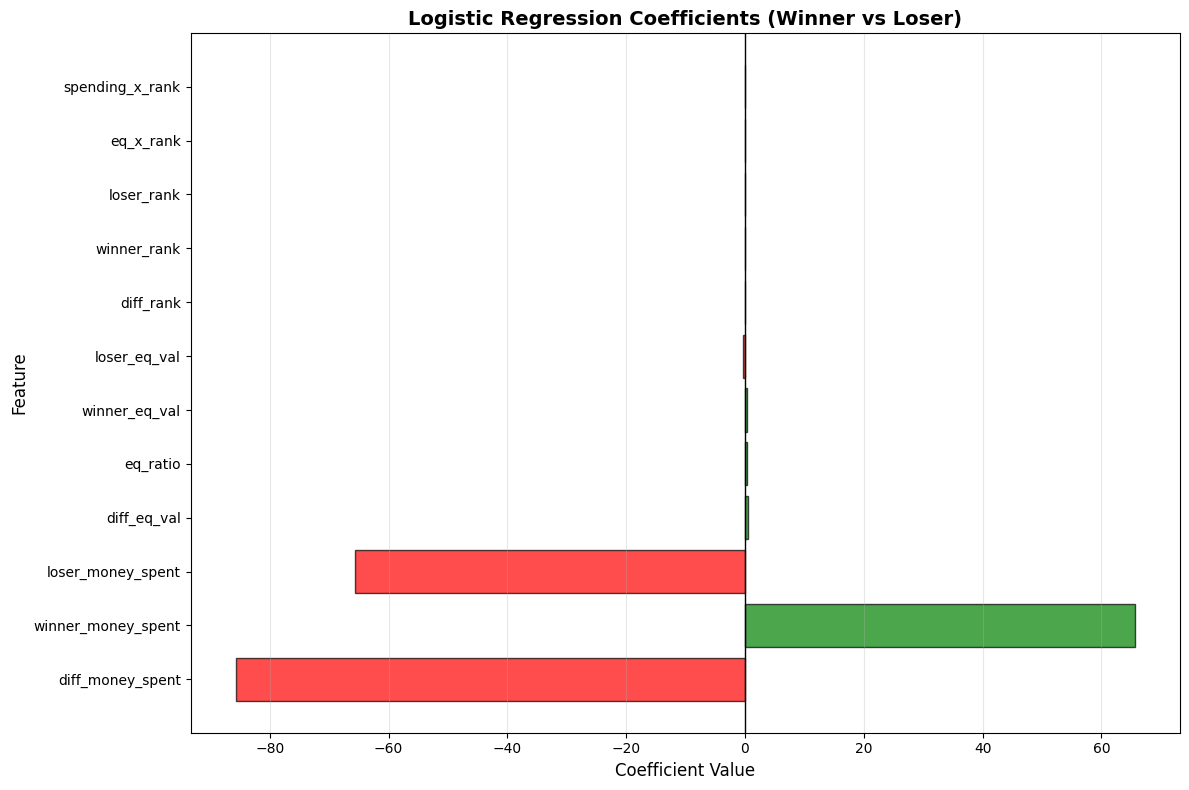


🔑 KEY INSIGHTS FROM FEATURE IMPORTANCE

Top 5 Most Important Features for Predicting Winners:
  • diff_money_spent
    → Advantage metric (positive = winner had more)
  • winner_money_spent
    → Winner's absolute value
  • loser_money_spent
    → Loser's absolute value (for comparison)
  • diff_eq_val
    → Advantage metric (positive = winner had more)
  • eq_ratio

💡 For ABM Implementation:
  - Focus on maintaining advantages in top features
  - Equipment and rank advantages are key predictors
  - Model can predict win probability given these metrics
  - Use this to optimize agent spending decisions


In [47]:
log_model = trained_models['Logistic Regression']
# For logistic regression, analyze coefficients
print("\n📊 LOGISTIC REGRESSION COEFFICIENTS")
print("="*70)

coefficients = log_model.coef_[0]
feature_names = X.columns

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients),
    'odds_ratio': np.exp(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("\nFeature Coefficients (sorted by absolute value):")
print(importance_df.to_string(index=False))

print("\n💡 Interpretation (Winner Perspective):")
print("  - Positive coefficient: increases probability of winning")
print("  - Negative coefficient: decreases probability of winning")
print("  - Odds ratio > 1: multiplicative increase in win odds")
print("  - Odds ratio < 1: multiplicative decrease in win odds")

# Plot coefficients
plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in importance_df['coefficient']]
plt.barh(importance_df['feature'], importance_df['coefficient'], color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Logistic Regression Coefficients (Winner vs Loser)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()



# Summary of key insights
print("\n" + "="*70)
print("🔑 KEY INSIGHTS FROM FEATURE IMPORTANCE")
print("="*70)

top_features = importance_df.head(5)
print("\nTop 5 Most Important Features for Predicting Winners:")
for idx, row in top_features.iterrows():
    feature_name = row['feature']
    print(f"  • {feature_name}")
    if 'diff_' in feature_name:
        print(f"    → Advantage metric (positive = winner had more)")
    elif 'winner_' in feature_name:
        print(f"    → Winner's absolute value")
    elif 'loser_' in feature_name:
        print(f"    → Loser's absolute value (for comparison)")

print("\n💡 For ABM Implementation:")
print("  - Focus on maintaining advantages in top features")
print("  - Equipment and rank advantages are key predictors")
print("  - Model can predict win probability given these metrics")
print("  - Use this to optimize agent spending decisions")

🔢 Analyzing Round Number Effects on Win Probability and Equipment...

📊 ROUND DISTRIBUTION
round_category
Pistol (1)            68776
Early (2-3)          137552
Mid (4-15)           825312
Late (16-24)         562308
Very Late (25-30)    177356
Overtime (30+)        51605
Name: count, dtype: int64

Total rounds analyzed: 1,822,909

💰 EQUIPMENT PATTERNS BY ROUND PHASE


C:\Users\peter\AppData\Local\Temp\ipykernel_1968\359968159.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eq_by_round = analysis_df.groupby('round_category').agg({



Winner Equipment Value by Round Phase:
                     mean     std    min     max
round_category                                  
Pistol (1)          843.0    71.0  200.0  1270.0
Early (2-3)        3845.0  1025.0  200.0  6400.0
Mid (4-15)         5196.0  1133.0  200.0  8110.0
Late (16-24)       4274.0  1719.0  200.0  8070.0
Very Late (25-30)  5220.0  1152.0  200.0  8030.0
Overtime (30+)     5870.0   654.0  200.0  7650.0

Loser Equipment Value by Round Phase:
                     mean     std    min     max
round_category                                  
Pistol (1)          842.0    73.0  200.0  1230.0
Early (2-3)        2071.0  1660.0  160.0  6480.0
Mid (4-15)         4065.0  1985.0  160.0  7980.0
Late (16-24)       3100.0  2105.0  160.0  7370.0
Very Late (25-30)  4267.0  1851.0  200.0  7530.0
Overtime (30+)     5739.0   694.0  200.0  7850.0

Equipment Advantage (Winner - Loser) by Round Phase:
                     mean     std
round_category                   
Pistol (1)     

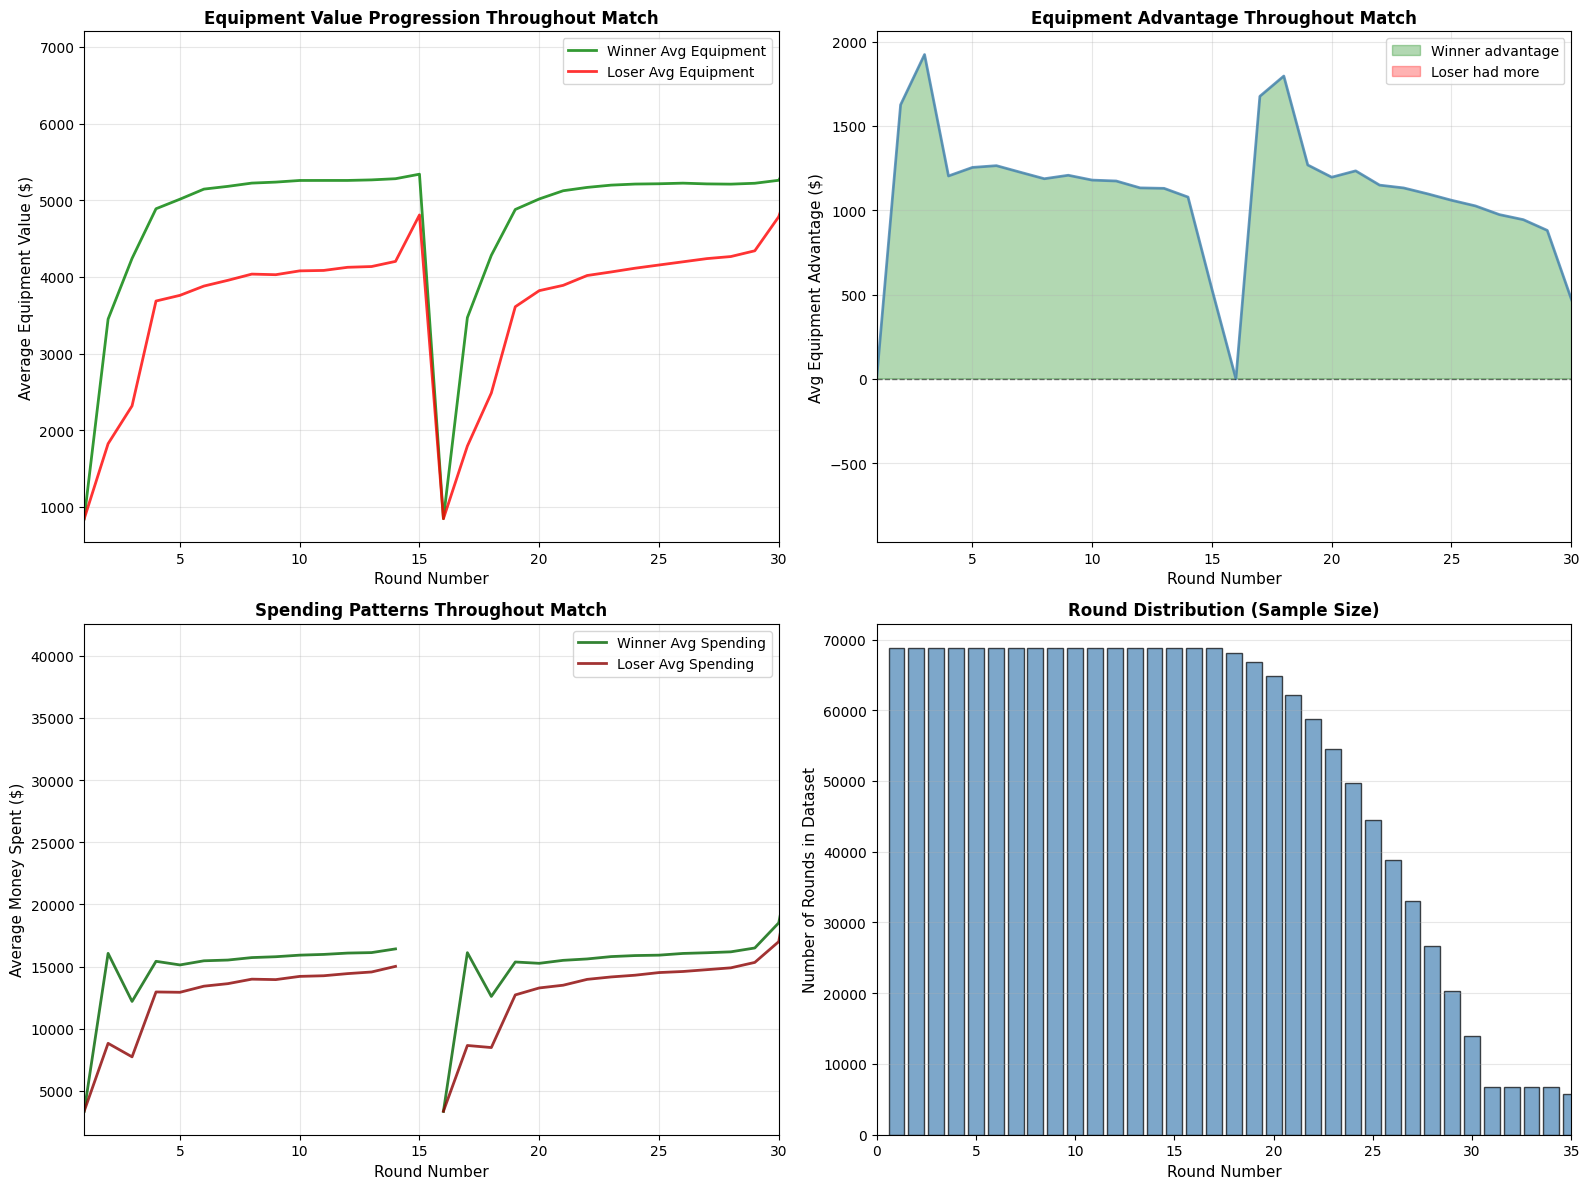


🎯 SPECIAL ROUND ANALYSIS

🔫 Pistol Rounds (Rounds 1 & 16):
   Count: 137,552
   Winner avg equipment: $845
   Loser avg equipment:  $844
   Equipment advantage:  $1

💼 Post-Pistol Rounds (2-3, 17-18):
   Count: 274,418
   Winner avg equipment: $3859
   Loser avg equipment:  $2104
   Equipment advantage:  $1755
   Note: Large advantages suggest pistol winners press advantage

⚔️  Mid-Game Rounds (4-15):
   Count: 825,312
   Winner avg equipment: $5196
   Loser avg equipment:  $4065
   Equipment advantage:  $1131

🔥 Late Game Rounds (16-24):
   Count: 562,308
   Winner avg equipment: $4274
   Loser avg equipment:  $3100
   Equipment advantage:  $1174

⏰ Overtime Rounds (25+):
   Count: 228,961
   Winner avg equipment: $5366
   Loser avg equipment:  $4599
   Equipment advantage:  $767
   Note: Starting money is $10,000 in overtime

📊 EQUIPMENT VOLATILITY BY ROUND PHASE

Equipment Advantage Volatility:
(Higher std = more varied equipment situations)
                  diff_eq_val          

C:\Users\peter\AppData\Local\Temp\ipykernel_1968\359968159.py:167: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volatility_df = analysis_df.groupby('round_category').agg({
C:\Users\peter\AppData\Local\Temp\ipykernel_1968\359968159.py:196: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_by_phase = analysis_df.groupby('round_category')['predicted_win_prob'].agg(['mean', 'std', 'min', 'max']).round(3)
C:\Users\peter\AppData\Local\Temp\ipykernel_1968\359968159.py:196: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to re


Average Win Probability by Round Phase:
(For winners, should be high; measures model confidence)
                    mean    std    min    max
round_category                               
Pistol (1)         0.507  0.050  0.149  0.926
Early (2-3)        0.706  0.243  0.014  0.990
Mid (4-15)         0.589  0.194  0.012  0.990
Late (16-24)       0.611  0.207  0.012  0.990
Very Late (25-30)  0.572  0.180  0.013  0.989
Overtime (30+)     0.508  0.066  0.153  0.911


C:\Users\peter\AppData\Local\Temp\ipykernel_1968\359968159.py:218: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([analysis_df[analysis_df['round_category'] == cat]['predicted_win_prob'].values


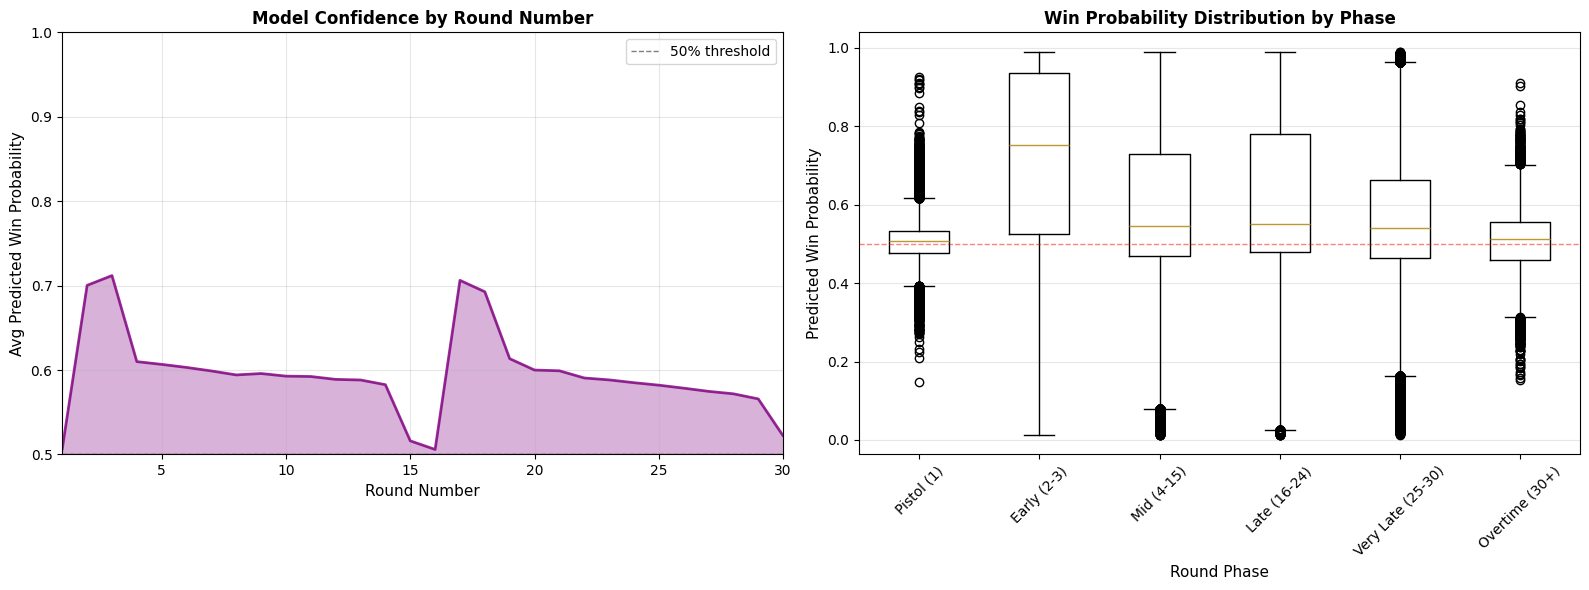


🔑 KEY INSIGHTS - ROUND NUMBER EFFECTS

1. PISTOL ROUNDS (Round 1):
   • Limited equipment ($800 starting money)
   • Small equipment advantages determine outcomes
   • Critical: winning pistol often leads to 2-3 round advantage

2. POST-PISTOL ROUNDS (Rounds 2-3):
   • Largest equipment disparities in the match
   • Pistol winners often have 3-5x equipment advantage
   • Losers typically eco or force buy

3. MID-GAME ROUNDS (Rounds 4-15):
   • Most balanced equipment situations
   • Both teams have economy established
   • Strategic eco rounds and force buys

4. SIDE SWITCH (Round 16):
   • Returns to pistol round dynamics
   • Economy resets ($800 starting money)

5. LATE GAME (Rounds 16-24):
   • Similar patterns to rounds 4-15
   • Higher stakes - closer to match point

6. OVERTIME (Round 25+):
   • $10,000 starting money (MR3 format)
   • More full-buy rounds
   • Less equipment variance

💡 ABM IMPLICATIONS:
   → Model round-specific starting money
   → Pistol rounds need differen

In [48]:
# 7. Round Number Effects Analysis

print("🔢 Analyzing Round Number Effects on Win Probability and Equipment...")
print("="*70)

if classification_data is not None and len(classification_data) > 0:
    
    # Add round number categories
    analysis_df = classification_data.copy()
    
    # CS:GO matches are typically best of 30 rounds (first to 16 wins)
    # Overtime adds 6-round increments
    analysis_df['round_category'] = pd.cut(
        analysis_df['round_num'],
        bins=[0, 1, 3, 15, 24, 30, 100],
        labels=['Pistol (1)', 'Early (2-3)', 'Mid (4-15)', 'Late (16-24)', 'Very Late (25-30)', 'Overtime (30+)']
    )
    
    print("\n📊 ROUND DISTRIBUTION")
    print("="*60)
    round_dist = analysis_df['round_category'].value_counts().sort_index()
    print(round_dist)
    print(f"\nTotal rounds analyzed: {len(analysis_df):,}")
    
    # Equipment patterns by round number
    print("\n💰 EQUIPMENT PATTERNS BY ROUND PHASE")
    print("="*60)
    
    eq_by_round = analysis_df.groupby('round_category').agg({
        'winner_eq_val': ['mean', 'std', 'min', 'max'],
        'loser_eq_val': ['mean', 'std', 'min', 'max'],
        'diff_eq_val': ['mean', 'std'],
        'winner_money_spent': ['mean', 'std'],
        'loser_money_spent': ['mean', 'std']
    }).round(0)
    
    print("\nWinner Equipment Value by Round Phase:")
    print(eq_by_round['winner_eq_val'])
    
    print("\nLoser Equipment Value by Round Phase:")
    print(eq_by_round['loser_eq_val'])
    
    print("\nEquipment Advantage (Winner - Loser) by Round Phase:")
    print(eq_by_round['diff_eq_val'])
    
    # Visualize equipment patterns over rounds
    print("\n📈 Plotting Equipment Patterns...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Equipment value by round number
    ax1 = axes[0, 0]
    round_eq = analysis_df.groupby('round_num').agg({
        'winner_eq_val': 'mean',
        'loser_eq_val': 'mean'
    })
    ax1.plot(round_eq.index, round_eq['winner_eq_val'], 
             label='Winner Avg Equipment', linewidth=2, color='green', alpha=0.8)
    ax1.plot(round_eq.index, round_eq['loser_eq_val'], 
             label='Loser Avg Equipment', linewidth=2, color='red', alpha=0.8)
    ax1.set_xlabel('Round Number', fontsize=11)
    ax1.set_ylabel('Average Equipment Value ($)', fontsize=11)
    ax1.set_title('Equipment Value Progression Throughout Match', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(1, 30)
    
    # Plot 2: Equipment advantage over rounds
    ax2 = axes[0, 1]
    round_diff = analysis_df.groupby('round_num')['diff_eq_val'].mean()
    ax2.plot(round_diff.index, round_diff.values, 
             linewidth=2, color='steelblue', alpha=0.8)
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax2.fill_between(round_diff.index, 0, round_diff.values, 
                     where=(round_diff.values > 0), alpha=0.3, color='green', label='Winner advantage')
    ax2.fill_between(round_diff.index, 0, round_diff.values, 
                     where=(round_diff.values < 0), alpha=0.3, color='red', label='Loser had more')
    ax2.set_xlabel('Round Number', fontsize=11)
    ax2.set_ylabel('Avg Equipment Advantage ($)', fontsize=11)
    ax2.set_title('Equipment Advantage Throughout Match', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(1, 30)
    
    # Plot 3: Money spent patterns
    ax3 = axes[1, 0]
    round_spending = analysis_df.groupby('round_num').agg({
        'winner_money_spent': 'mean',
        'loser_money_spent': 'mean'
    })
    ax3.plot(round_spending.index, round_spending['winner_money_spent'], 
             label='Winner Avg Spending', linewidth=2, color='darkgreen', alpha=0.8)
    ax3.plot(round_spending.index, round_spending['loser_money_spent'], 
             label='Loser Avg Spending', linewidth=2, color='darkred', alpha=0.8)
    ax3.set_xlabel('Round Number', fontsize=11)
    ax3.set_ylabel('Average Money Spent ($)', fontsize=11)
    ax3.set_title('Spending Patterns Throughout Match', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(1, 30)
    
    # Plot 4: Round count distribution
    ax4 = axes[1, 1]
    round_counts = analysis_df['round_num'].value_counts().sort_index()
    ax4.bar(round_counts.index, round_counts.values, 
            color='steelblue', alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Round Number', fontsize=11)
    ax4.set_ylabel('Number of Rounds in Dataset', fontsize=11)
    ax4.set_title('Round Distribution (Sample Size)', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.set_xlim(0, 35)
    
    plt.tight_layout()
    plt.show()
    
    # Special round analysis
    print("\n🎯 SPECIAL ROUND ANALYSIS")
    print("="*60)
    
    # Pistol rounds (round 1 and 16)
    pistol_rounds = analysis_df[analysis_df['round_num'].isin([1, 16])]
    print(f"\n🔫 Pistol Rounds (Rounds 1 & 16):")
    print(f"   Count: {len(pistol_rounds):,}")
    print(f"   Winner avg equipment: ${pistol_rounds['winner_eq_val'].mean():.0f}")
    print(f"   Loser avg equipment:  ${pistol_rounds['loser_eq_val'].mean():.0f}")
    print(f"   Equipment advantage:  ${pistol_rounds['diff_eq_val'].mean():.0f}")
    
    # Early rounds (2-3) - often force buys or ecos
    early_rounds = analysis_df[analysis_df['round_num'].isin([2, 3, 17, 18])]
    print(f"\n💼 Post-Pistol Rounds (2-3, 17-18):")
    print(f"   Count: {len(early_rounds):,}")
    print(f"   Winner avg equipment: ${early_rounds['winner_eq_val'].mean():.0f}")
    print(f"   Loser avg equipment:  ${early_rounds['loser_eq_val'].mean():.0f}")
    print(f"   Equipment advantage:  ${early_rounds['diff_eq_val'].mean():.0f}")
    print(f"   Note: Large advantages suggest pistol winners press advantage")
    
    # Mid-game rounds (4-15)
    mid_rounds = analysis_df[(analysis_df['round_num'] >= 4) & (analysis_df['round_num'] <= 15)]
    print(f"\n⚔️  Mid-Game Rounds (4-15):")
    print(f"   Count: {len(mid_rounds):,}")
    print(f"   Winner avg equipment: ${mid_rounds['winner_eq_val'].mean():.0f}")
    print(f"   Loser avg equipment:  ${mid_rounds['loser_eq_val'].mean():.0f}")
    print(f"   Equipment advantage:  ${mid_rounds['diff_eq_val'].mean():.0f}")
    
    # Late rounds (16-24) - side switch + crucial rounds
    late_rounds = analysis_df[(analysis_df['round_num'] >= 16) & (analysis_df['round_num'] <= 24)]
    print(f"\n🔥 Late Game Rounds (16-24):")
    print(f"   Count: {len(late_rounds):,}")
    print(f"   Winner avg equipment: ${late_rounds['winner_eq_val'].mean():.0f}")
    print(f"   Loser avg equipment:  ${late_rounds['loser_eq_val'].mean():.0f}")
    print(f"   Equipment advantage:  ${late_rounds['diff_eq_val'].mean():.0f}")
    
    # Overtime rounds (25+)
    overtime_rounds = analysis_df[analysis_df['round_num'] >= 25]
    if len(overtime_rounds) > 0:
        print(f"\n⏰ Overtime Rounds (25+):")
        print(f"   Count: {len(overtime_rounds):,}")
        print(f"   Winner avg equipment: ${overtime_rounds['winner_eq_val'].mean():.0f}")
        print(f"   Loser avg equipment:  ${overtime_rounds['loser_eq_val'].mean():.0f}")
        print(f"   Equipment advantage:  ${overtime_rounds['diff_eq_val'].mean():.0f}")
        print(f"   Note: Starting money is $10,000 in overtime")
    
    # Volatility analysis
    print("\n📊 EQUIPMENT VOLATILITY BY ROUND PHASE")
    print("="*60)
    
    volatility_df = analysis_df.groupby('round_category').agg({
        'diff_eq_val': ['std', 'min', 'max'],
        'winner_eq_val': 'std',
        'loser_eq_val': 'std'
    }).round(0)
    
    print("\nEquipment Advantage Volatility:")
    print("(Higher std = more varied equipment situations)")
    print(volatility_df)
    
    # Win probability predictions by round phase (if model exists)
    if best_model_name is not None and len(trained_models) > 0:
        print("\n🎲 WIN PROBABILITY PATTERNS BY ROUND PHASE")
        print("="*60)
        
        # Add predictions to analysis_df
        X_round = analysis_df[feature_columns].copy()
        X_round['eq_x_rank'] = X_round['diff_eq_val'] * X_round['diff_rank']
        X_round['spending_x_rank'] = X_round['diff_money_spent'] * X_round['diff_rank']
        X_round['eq_ratio'] = X_round['winner_eq_val'] / (X_round['loser_eq_val'] + 1)
        
        if best_model_name == 'Logistic Regression':
            X_round_pred = scaler.transform(X_round)
        else:
            X_round_pred = X_round
        
        round_predictions = trained_models[best_model_name].predict_proba(X_round_pred)[:, 1]
        analysis_df['predicted_win_prob'] = round_predictions
        
        prob_by_phase = analysis_df.groupby('round_category')['predicted_win_prob'].agg(['mean', 'std', 'min', 'max']).round(3)
        print("\nAverage Win Probability by Round Phase:")
        print("(For winners, should be high; measures model confidence)")
        print(prob_by_phase)
        
        # Plot win probability over rounds
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Win probability by round number
        round_prob = analysis_df.groupby('round_num')['predicted_win_prob'].mean()
        ax1.plot(round_prob.index, round_prob.values, linewidth=2, color='purple', alpha=0.8)
        ax1.axhline(y=0.5, color='black', linestyle='--', linewidth=1, alpha=0.5, label='50% threshold')
        ax1.fill_between(round_prob.index, 0.5, round_prob.values, alpha=0.3, color='purple')
        ax1.set_xlabel('Round Number', fontsize=11)
        ax1.set_ylabel('Avg Predicted Win Probability', fontsize=11)
        ax1.set_title('Model Confidence by Round Number', fontsize=12, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(1, 30)
        ax1.set_ylim(0.5, 1.0)
        
        # Box plot by phase
        ax2.boxplot([analysis_df[analysis_df['round_category'] == cat]['predicted_win_prob'].values 
                     for cat in analysis_df['round_category'].cat.categories],
                    labels=analysis_df['round_category'].cat.categories)
        ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
        ax2.set_ylabel('Predicted Win Probability', fontsize=11)
        ax2.set_xlabel('Round Phase', fontsize=11)
        ax2.set_title('Win Probability Distribution by Phase', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    # Key insights
    print("\n" + "="*70)
    print("🔑 KEY INSIGHTS - ROUND NUMBER EFFECTS")
    print("="*70)
    
    print("\n1. PISTOL ROUNDS (Round 1):")
    print("   • Limited equipment ($800 starting money)")
    print("   • Small equipment advantages determine outcomes")
    print("   • Critical: winning pistol often leads to 2-3 round advantage")
    
    print("\n2. POST-PISTOL ROUNDS (Rounds 2-3):")
    print("   • Largest equipment disparities in the match")
    print("   • Pistol winners often have 3-5x equipment advantage")
    print("   • Losers typically eco or force buy")
    
    print("\n3. MID-GAME ROUNDS (Rounds 4-15):")
    print("   • Most balanced equipment situations")
    print("   • Both teams have economy established")
    print("   • Strategic eco rounds and force buys")
    
    print("\n4. SIDE SWITCH (Round 16):")
    print("   • Returns to pistol round dynamics")
    print("   • Economy resets ($800 starting money)")
    
    print("\n5. LATE GAME (Rounds 16-24):")
    print("   • Similar patterns to rounds 4-15")
    print("   • Higher stakes - closer to match point")
    
    if len(overtime_rounds) > 0:
        print("\n6. OVERTIME (Round 25+):")
        print("   • $10,000 starting money (MR3 format)")
        print("   • More full-buy rounds")
        print("   • Less equipment variance")
    
    print("\n💡 ABM IMPLICATIONS:")
    print("   → Model round-specific starting money")
    print("   → Pistol rounds need different strategy (limited options)")
    print("   → Post-pistol rounds: winners press advantage, losers eco")
    print("   → Mid-game: complex economy decisions matter most")
    print("   → Track momentum from pistol round wins")
    
else:
    print("❌ No data available for round number analysis")


⚔️ Analyzing CT vs T Side Effects on Win Probability and Economy...
Note: CS:GO is asymmetric - CT equipment is more expensive, T gets bomb plant bonus

🔍 Querying data with CT/T side information...


C:\Users\peter\AppData\Local\Temp\ipykernel_1968\1725517393.py:104: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ct_t_data = pd.read_sql(ct_t_query, conn)


✅ Retrieved 1,822,909 rounds with side information

📊 SIDE DISTRIBUTION

Winning Side Distribution:
  CT Wins: 940,130 (51.6%)
  T Wins:  882,779 (48.4%)

💰 EQUIPMENT ANALYSIS BY SIDE

CT Side Wins:
  Avg CT equipment (winner): $4935
  Avg T equipment (loser):   $3468
  Avg equipment advantage:   $1467
  Avg CT spending:           $14911

T Side Wins:
  Avg T equipment (winner):  $4381
  Avg CT equipment (loser):  $3662
  Avg equipment advantage:   $719
  Avg T spending:            $14592

⚖️ EQUIPMENT ADVANTAGE REQUIRED TO WIN BY SIDE

CT Side Wins:
  Avg CT equipment (winner): $4935
  Avg T equipment (loser):   $3468
  Avg equipment advantage:   $1467
  Avg CT spending:           $14911

T Side Wins:
  Avg T equipment (winner):  $4381
  Avg CT equipment (loser):  $3662
  Avg equipment advantage:   $719
  Avg T spending:            $14592

⚖️ EQUIPMENT ADVANTAGE REQUIRED TO WIN BY SIDE


C:\Users\peter\AppData\Local\Temp\ipykernel_1968\1725517393.py:146: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  side_eq_analysis = ct_t_data.groupby(['winner_side', 'eq_adv_bin']).size().unstack(fill_value=0)



Percentage of wins by equipment advantage:
(Shows how much advantage each side needs to win)
eq_adv_bin   < -$2000  -$2000 to -$1000  -$1000 to $0  $0 to $1000  \
winner_side                                                          
CT                5.9               4.1          13.6         24.4   
T                 9.0              14.0          24.0         14.5   

eq_adv_bin   $1000 to $2000  > $2000  
winner_side                           
CT                     18.0     34.0  
T                       7.4     31.2  

📈 Plotting CT vs T Analysis...


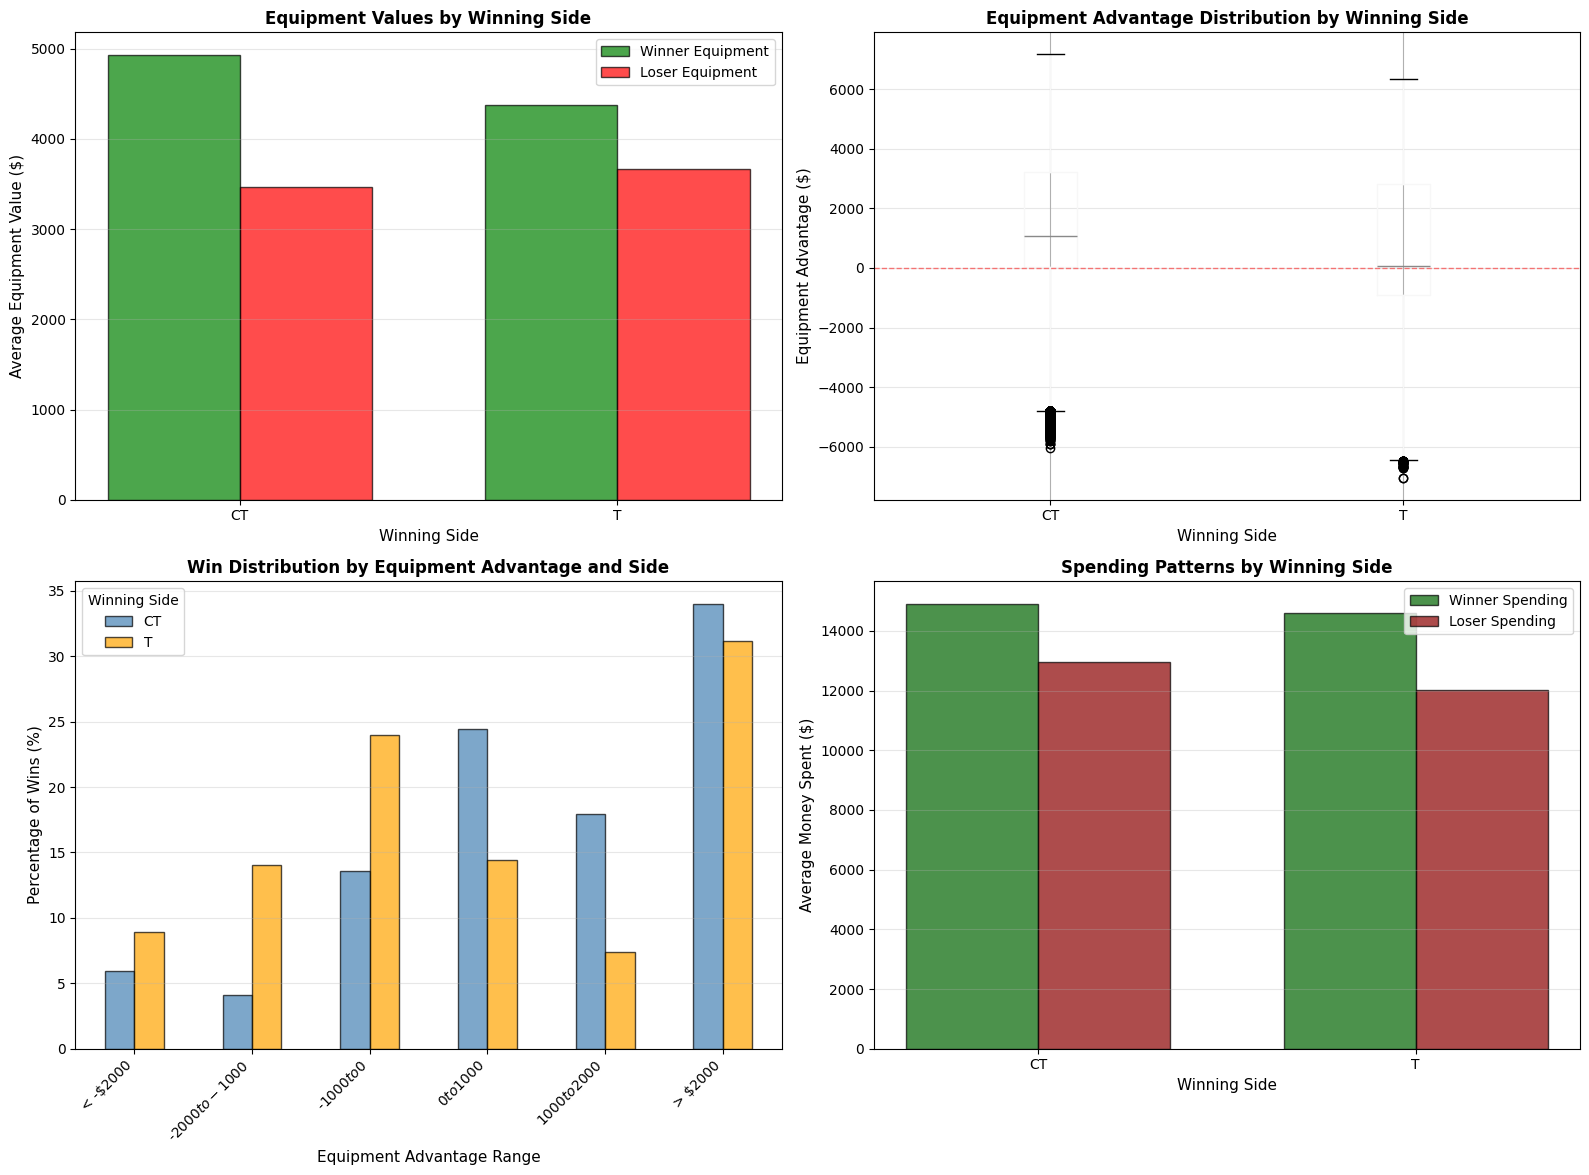


📊 STATISTICAL SIGNIFICANCE TEST

T-test: CT vs T equipment advantage when winning
  CT mean advantage: $1467
  T mean advantage:  $719
  Difference: $748
  T-statistic: 216.306
  P-value: 0.000000
  ✅ Statistically significant difference (p < 0.05)

🔑 KEY INSIGHTS - CT vs T SIDE ANALYSIS

1. SIDE BALANCE:
   • CT win rate: 51.6%
   • T win rate: 48.4%
   • Relatively balanced (within 3% of 50/50)

2. EQUIPMENT COSTS:
   • CT average spending: $14911
   • T average spending: $14592
   • Difference: $319
   • CT equipment is typically more expensive (M4 vs AK, utility)

3. EQUIPMENT ADVANTAGE NEEDED:
   • CT needs $1467 avg advantage to win
   • T needs $719 avg advantage to win
   • Significant difference in advantage requirements

💡 ABM IMPLICATIONS:
   → Model different equipment costs for CT vs T
   → CT agents should account for higher weapon costs
   → T agents get $800 bomb plant bonus (analyzed in next cell)
   → Adjust win probability calculations by side
   → Consider side-spe

In [63]:
# 8. CT vs T Side Analysis - Critical for CS:GO Asymmetry

print("⚔️ Analyzing CT vs T Side Effects on Win Probability and Economy...")
print("="*70)
print("Note: CS:GO is asymmetric - CT equipment is more expensive, T gets bomb plant bonus")

# Query data with CT/T side information
ct_t_query = """
WITH team_round_data AS (
    SELECT 
        r.id as round_id,
        r.id_demo_exports as id_demo_exports,
        r.round_num,
        r.team1_winner,
        r.is_ct_t1 as team1_ct,  -- TRUE if team 1 is CT side
        -- Team 1 aggregated metrics
        AVG(CASE WHEN pr.team = 1 THEN pr.eq_val_fte END) as t1_eq_val,
        SUM(CASE WHEN pr.team = 1 THEN pe.money_spent END) as t1_money_spent,
        -- Team 2 aggregated metrics  
        AVG(CASE WHEN pr.team = 2 THEN pr.eq_val_fte END) as t2_eq_val,
        SUM(CASE WHEN pr.team = 2 THEN pe.money_spent END) as t2_money_spent,
        -- Bomb plant information (important for T-side economy)
        CASE WHEN r.round_end_reason = 1 or r.round_end_reason = 7 THEN TRUE ELSE FALSE END as bomb_planted,
        -- HLTV rankings
        hmi.team_1_id,
        hmi.team_2_id,
        hmi.event_id
    FROM rounds_ed r
    JOIN player_round_ed pr ON r.id = pr.round_id
    LEFT JOIN player_economy_ed pe ON pr.id = pe.player_round_id
    LEFT JOIN hltv_match_info hmi ON r.match_id = hmi.match_id
    WHERE r.team1_winner IS NOT NULL
        AND pr.team IN (1, 2)
        AND pr.eq_val_fte IS NOT NULL
        AND hmi.event_id IS NOT NULL
        AND r.is_ct_t1 IS NOT NULL  -- Need side information
    GROUP BY r.id, r.id_demo_exports, r.round_num, r.team1_winner, r.is_ct_t1, r.round_end_reason,
             hmi.team_1_id, hmi.team_2_id, hmi.event_id
    HAVING COUNT(CASE WHEN pr.team = 1 THEN 1 END) = 5 
       AND COUNT(CASE WHEN pr.team = 2 THEN 1 END) = 5
),
ranked_data AS (
    SELECT 
        trd.round_id,
        trd.id_demo_exports,
        trd.round_num,
        trd.team1_winner,
        trd.team1_ct,
        trd.bomb_planted,
        -- Team 1 metrics
        trd.t1_eq_val,
        trd.t1_money_spent,
        CAST(het1.rank_during AS INTEGER) as t1_rank,
        -- Team 2 metrics
        trd.t2_eq_val,
        trd.t2_money_spent,
        CAST(het2.rank_during AS INTEGER) as t2_rank
    FROM team_round_data trd
    LEFT JOIN hltv_events_teams het1 ON het1.team_id = trd.team_1_id AND het1.event_id = trd.event_id
    LEFT JOIN hltv_events_teams het2 ON het2.team_id = trd.team_2_id AND het2.event_id = trd.event_id
    WHERE het1.rank_during IS NOT NULL 
        AND het2.rank_during IS NOT NULL
        AND trd.t1_eq_val IS NOT NULL 
        AND trd.t2_eq_val IS NOT NULL
)
-- Restructure: WINNER vs LOSER with SIDE information
SELECT 
    round_id,
    id_demo_exports,
    round_num,
    bomb_planted,
    -- Determine winner's side (CT or T)
    CASE 
        WHEN team1_winner = true AND team1_ct = true THEN 'CT'
        WHEN team1_winner = true AND team1_ct = false THEN 'T'
        WHEN team1_winner = false AND team1_ct = true THEN 'T'
        WHEN team1_winner = false AND team1_ct = false THEN 'CT'
    END as winner_side,
    -- Determine loser's side
    CASE 
        WHEN team1_winner = false AND team1_ct = true THEN 'CT'
        WHEN team1_winner = false AND team1_ct = false THEN 'T'
        WHEN team1_winner = true AND team1_ct = true THEN 'T'
        WHEN team1_winner = true AND team1_ct = false THEN 'CT'
    END as loser_side,
    -- Winner metrics (conditional based on who won)
    CASE WHEN team1_winner = true THEN t1_eq_val ELSE t2_eq_val END as winner_eq_val,
    CASE WHEN team1_winner = true THEN t1_money_spent ELSE t2_money_spent END as winner_money_spent,
    CASE WHEN team1_winner = true THEN t1_rank ELSE t2_rank END as winner_rank,
    -- Loser metrics
    CASE WHEN team1_winner = false THEN t1_eq_val ELSE t2_eq_val END as loser_eq_val,
    CASE WHEN team1_winner = false THEN t1_money_spent ELSE t2_money_spent END as loser_money_spent,
    CASE WHEN team1_winner = false THEN t1_rank ELSE t2_rank END as loser_rank,
    -- Advantages
    CASE WHEN team1_winner = true THEN (t1_eq_val - t2_eq_val) ELSE (t2_eq_val - t1_eq_val) END as diff_eq_val,
    CASE WHEN team1_winner = true THEN (t1_money_spent - t2_money_spent) ELSE (t2_money_spent - t1_money_spent) END as diff_money_spent,
    CASE WHEN team1_winner = true THEN (t2_rank - t1_rank) ELSE (t1_rank - t2_rank) END as diff_rank
FROM ranked_data
ORDER BY id_demo_exports, round_num
"""

try:
    print("\n🔍 Querying data with CT/T side information...")
    ct_t_data = pd.read_sql(ct_t_query, conn)
    print(f"✅ Retrieved {len(ct_t_data):,} rounds with side information")
    
    # Basic side distribution
    print("\n📊 SIDE DISTRIBUTION")
    print("="*60)
    side_dist = ct_t_data['winner_side'].value_counts()
    print("\nWinning Side Distribution:")
    print(f"  CT Wins: {side_dist.get('CT', 0):,} ({side_dist.get('CT', 0)/len(ct_t_data)*100:.1f}%)")
    print(f"  T Wins:  {side_dist.get('T', 0):,} ({side_dist.get('T', 0)/len(ct_t_data)*100:.1f}%)")
    
    # Equipment analysis by side
    print("\n💰 EQUIPMENT ANALYSIS BY SIDE")
    print("="*60)
    
    ct_rounds = ct_t_data[ct_t_data['winner_side'] == 'CT']
    t_rounds = ct_t_data[ct_t_data['winner_side'] == 'T']
    
    print("\nCT Side Wins:")
    print(f"  Avg CT equipment (winner): ${ct_rounds['winner_eq_val'].mean():.0f}")
    print(f"  Avg T equipment (loser):   ${ct_rounds['loser_eq_val'].mean():.0f}")
    print(f"  Avg equipment advantage:   ${ct_rounds['diff_eq_val'].mean():.0f}")
    print(f"  Avg CT spending:           ${ct_rounds['winner_money_spent'].mean():.0f}")
    
    print("\nT Side Wins:")
    print(f"  Avg T equipment (winner):  ${t_rounds['winner_eq_val'].mean():.0f}")
    print(f"  Avg CT equipment (loser):  ${t_rounds['loser_eq_val'].mean():.0f}")
    print(f"  Avg equipment advantage:   ${t_rounds['diff_eq_val'].mean():.0f}")
    print(f"  Avg T spending:            ${t_rounds['winner_money_spent'].mean():.0f}")
    
    # Equipment advantage needed to win
    print("\n⚖️ EQUIPMENT ADVANTAGE REQUIRED TO WIN BY SIDE")
    print("="*60)
    
    # Bin equipment advantages
    eq_bins = [-float('inf'), -2000, -1000, 0, 1000, 2000, float('inf')]
    eq_labels = ['< -$2000', '-$2000 to -$1000', '-$1000 to $0', 
                 '$0 to $1000', '$1000 to $2000', '> $2000']
    
    ct_t_data['eq_adv_bin'] = pd.cut(ct_t_data['diff_eq_val'], bins=eq_bins, labels=eq_labels)
    
    # Win rate by equipment advantage and side
    side_eq_analysis = ct_t_data.groupby(['winner_side', 'eq_adv_bin']).size().unstack(fill_value=0)
    side_eq_pct = side_eq_analysis.div(side_eq_analysis.sum(axis=1), axis=0) * 100
    
    print("\nPercentage of wins by equipment advantage:")
    print("(Shows how much advantage each side needs to win)")
    print(side_eq_pct.round(1))
    
    # Visualizations
    print("\n📈 Plotting CT vs T Analysis...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Equipment comparison by side
    ax1 = axes[0, 0]
    side_eq = ct_t_data.groupby('winner_side').agg({
        'winner_eq_val': 'mean',
        'loser_eq_val': 'mean'
    })
    x = range(len(side_eq.index))
    width = 0.35
    ax1.bar([i - width/2 for i in x], side_eq['winner_eq_val'], width, 
            label='Winner Equipment', color='green', alpha=0.7, edgecolor='black')
    ax1.bar([i + width/2 for i in x], side_eq['loser_eq_val'], width, 
            label='Loser Equipment', color='red', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Winning Side', fontsize=11)
    ax1.set_ylabel('Average Equipment Value ($)', fontsize=11)
    ax1.set_title('Equipment Values by Winning Side', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(side_eq.index)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Equipment advantage distribution
    ax2 = axes[0, 1]
    ct_t_data.boxplot(column='diff_eq_val', by='winner_side', ax=ax2)
    ax2.set_xlabel('Winning Side', fontsize=11)
    ax2.set_ylabel('Equipment Advantage ($)', fontsize=11)
    ax2.set_title('Equipment Advantage Distribution by Winning Side', fontsize=12, fontweight='bold')
    ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    plt.sca(ax2)
    plt.xticks(rotation=0)
    ax2.get_figure().suptitle('')  # Remove auto-generated title
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Win rate by equipment advantage bins
    ax3 = axes[1, 0]
    side_eq_pct.T.plot(kind='bar', ax=ax3, color=['steelblue', 'orange'], alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Equipment Advantage Range', fontsize=11)
    ax3.set_ylabel('Percentage of Wins (%)', fontsize=11)
    ax3.set_title('Win Distribution by Equipment Advantage and Side', fontsize=12, fontweight='bold')
    ax3.legend(title='Winning Side', fontsize=10)
    ax3.grid(True, alpha=0.3, axis='y')
    plt.sca(ax3)
    plt.xticks(rotation=45, ha='right')
    
    # Plot 4: Average spending by side
    ax4 = axes[1, 1]
    spending_by_side = ct_t_data.groupby('winner_side').agg({
        'winner_money_spent': 'mean',
        'loser_money_spent': 'mean'
    })
    x = range(len(spending_by_side.index))
    ax4.bar([i - width/2 for i in x], spending_by_side['winner_money_spent'], width, 
            label='Winner Spending', color='darkgreen', alpha=0.7, edgecolor='black')
    ax4.bar([i + width/2 for i in x], spending_by_side['loser_money_spent'], width, 
            label='Loser Spending', color='darkred', alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Winning Side', fontsize=11)
    ax4.set_ylabel('Average Money Spent ($)', fontsize=11)
    ax4.set_title('Spending Patterns by Winning Side', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(spending_by_side.index)
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical significance test
    print("\n📊 STATISTICAL SIGNIFICANCE TEST")
    print("="*60)
    
    from scipy.stats import ttest_ind
    
    ct_eq_adv = ct_rounds['diff_eq_val']
    t_eq_adv = t_rounds['diff_eq_val']
    
    t_stat, p_value = ttest_ind(ct_eq_adv, t_eq_adv)
    print(f"\nT-test: CT vs T equipment advantage when winning")
    print(f"  CT mean advantage: ${ct_eq_adv.mean():.0f}")
    print(f"  T mean advantage:  ${t_eq_adv.mean():.0f}")
    print(f"  Difference: ${ct_eq_adv.mean() - t_eq_adv.mean():.0f}")
    print(f"  T-statistic: {t_stat:.3f}")
    print(f"  P-value: {p_value:.6f}")
    
    if p_value < 0.05:
        print(f"  ✅ Statistically significant difference (p < 0.05)")
    else:
        print(f"  ❌ No statistically significant difference (p >= 0.05)")
    
    # Key insights
    print("\n" + "="*70)
    print("🔑 KEY INSIGHTS - CT vs T SIDE ANALYSIS")
    print("="*70)
    
    ct_win_rate = side_dist.get('CT', 0) / len(ct_t_data) * 100
    t_win_rate = side_dist.get('T', 0) / len(ct_t_data) * 100
    
    print(f"\n1. SIDE BALANCE:")
    print(f"   • CT win rate: {ct_win_rate:.1f}%")
    print(f"   • T win rate: {t_win_rate:.1f}%")
    if abs(ct_win_rate - 50) < 3:
        print(f"   • Relatively balanced (within 3% of 50/50)")
    elif ct_win_rate > t_win_rate:
        print(f"   • CT-sided meta (CTs win {ct_win_rate - t_win_rate:.1f}% more often)")
    else:
        print(f"   • T-sided meta (Ts win {t_win_rate - ct_win_rate:.1f}% more often)")
    
    print(f"\n2. EQUIPMENT COSTS:")
    print(f"   • CT average spending: ${ct_rounds['winner_money_spent'].mean():.0f}")
    print(f"   • T average spending: ${t_rounds['winner_money_spent'].mean():.0f}")
    print(f"   • Difference: ${abs(ct_rounds['winner_money_spent'].mean() - t_rounds['winner_money_spent'].mean()):.0f}")
    print(f"   • CT equipment is typically more expensive (M4 vs AK, utility)")
    
    print(f"\n3. EQUIPMENT ADVANTAGE NEEDED:")
    print(f"   • CT needs ${ct_eq_adv.mean():.0f} avg advantage to win")
    print(f"   • T needs ${t_eq_adv.mean():.0f} avg advantage to win")
    if abs(ct_eq_adv.mean() - t_eq_adv.mean()) > 200:
        print(f"   • Significant difference in advantage requirements")
    
    print(f"\n💡 ABM IMPLICATIONS:")
    print(f"   → Model different equipment costs for CT vs T")
    print(f"   → CT agents should account for higher weapon costs")
    print(f"   → T agents get $800 bomb plant bonus (analyzed in next cell)")
    print(f"   → Adjust win probability calculations by side")
    print(f"   → Consider side-specific strategies (CT holds, T executes)")
    
    # Store for use in bomb plant analysis
    print(f"\n✅ Data stored in 'ct_t_data' variable for further analysis")
    
except Exception as e:
    print(f"❌ Query error: {e}")
    print("   Note: Your database may not have 'team1_ct' field")
    print("   Skipping CT/T side analysis")
    ct_t_data = None


💣 Analyzing Bomb Plant Impact and Loss Bonus Economics...
Core CS:GO Economy Mechanics:
  • Bomb plant: +$800 bonus for losing T side
  • Loss bonus: $1,400 → $1,900 → $2,400 → $2,900 (maxes at 4th loss)
  • Win resets loss bonus to $1,400

💣 BOMB PLANT IMPACT ANALYSIS

T-Side Losses with Bomb Plant Information:
  Total T losses: 940,130
  Bomb planted: 229,510 (24.4%)
  No bomb plant: 710,620 (75.6%)

📊 Equipment in T-Side Losses by Bomb Plant:

T-Side Losses with Bomb Plant Information:
  Total T losses: 940,130
  Bomb planted: 229,510 (24.4%)
  No bomb plant: 710,620 (75.6%)

📊 Equipment in T-Side Losses by Bomb Plant:

With Bomb Plant (gets $800 bonus next round):
  Avg T equipment (loser): $3676
  Avg CT equipment (winner): $4710
  Equipment deficit: $1033
  Avg T spending: $13605

Without Bomb Plant:
  Avg T equipment (loser): $3401
  Avg CT equipment (winner): $5008
  Equipment deficit: $1607
  Avg T spending: $12733

📊 Statistical Test:
  T-statistic: 58.494
  P-value: 0.000000

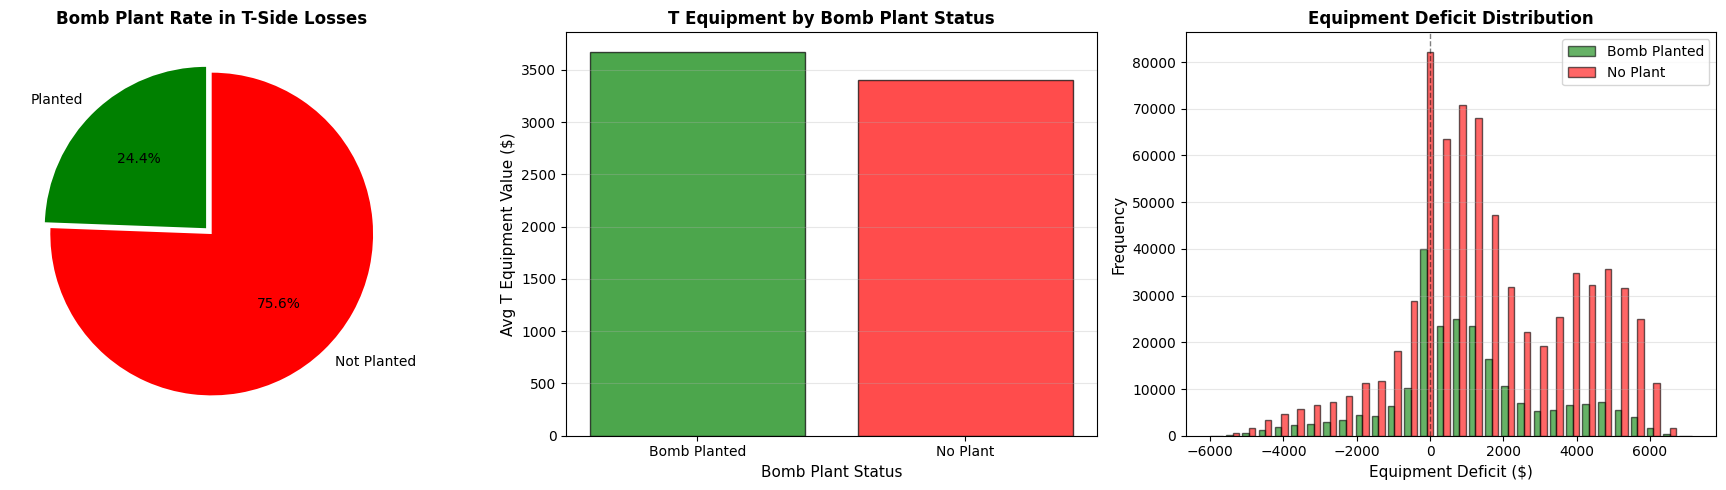



💰 BUYING STRATEGY CLASSIFICATION
Classifying rounds by spending patterns:

Strategy Distribution:
             Winner Strategy  Loser Strategy
Eco/Save              180413          513377
Force Buy              63473           83629
Full Buy             1254210          886109
Pistol/Weak            54296          159464
Semi-Buy              270517          180330


⚔️ STRATEGY MATCHUPS
Win rates for different strategy combinations:

Strategy Distribution:
             Winner Strategy  Loser Strategy
Eco/Save              180413          513377
Force Buy              63473           83629
Full Buy             1254210          886109
Pistol/Weak            54296          159464
Semi-Buy              270517          180330


⚔️ STRATEGY MATCHUPS
Win rates for different strategy combinations:

Win Rate Matrix (rows = winner strategy, columns = loser strategy):
loser_strategy   Eco/Save  Force Buy  Full Buy  Pistol/Weak  Semi-Buy
winner_strategy                                          

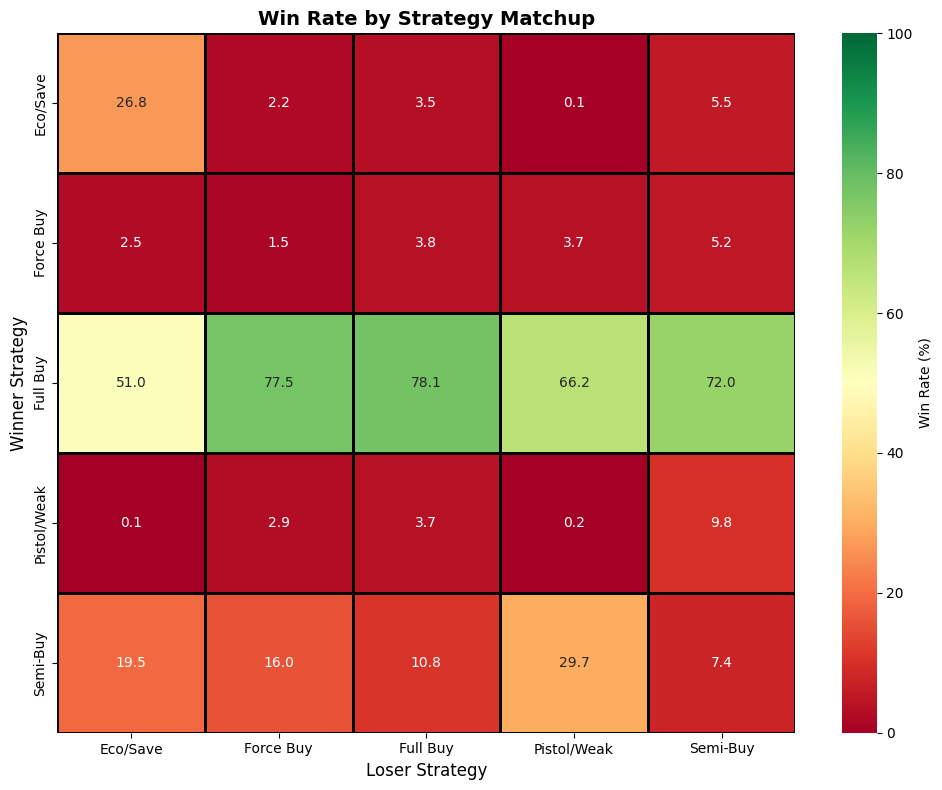



💵 EXPECTED VALUE ANALYSIS
Calculating EV of different strategies:

Force Buy Strategy:
  Rounds: 63,473
  Avg spending: $14106
  Avg opponent equipment: $3928
  Equipment deficit: $847

Eco/Save Strategy:
  Rounds: 180,413
  Avg spending: $3770
  Avg opponent equipment: $1853
  Equipment deficit: $987
  Note: These are ECO WINS (rare but high value)

Full Buy Strategy:
  Rounds: 1,254,210
  Avg spending: $16359
  Avg opponent equipment: $3880
  Equipment advantage: $1659

🔑 KEY INSIGHTS - BOMB PLANT & LOSS BONUS ECONOMICS

1. BOMB PLANT BEHAVIOR:
   • T-side plants bomb in 24.4% of losing rounds
   • Planting gives $800 bonus next round
   • This equals the difference between eco and force buy
   • Teams with higher investment tend to plant more

2. STRATEGY EFFECTIVENESS:
   • Force buy vs Eco win rate: 2.5%
   • Full buy vs Force buy win rate: 77.5%
   • Force buying is risky but can break economy cycles

3. ECONOMY DECISIONS:
   • Full buys dominate winning rounds (68.8%)
   • For

In [64]:
# 9. Bomb Plant & Loss Bonus Economics Analysis

print("💣 Analyzing Bomb Plant Impact and Loss Bonus Economics...")
print("="*70)
print("Core CS:GO Economy Mechanics:")
print("  • Bomb plant: +$800 bonus for losing T side")
print("  • Loss bonus: $1,400 → $1,900 → $2,400 → $2,900 (maxes at 4th loss)")
print("  • Win resets loss bonus to $1,400")

if ct_t_data is not None and len(ct_t_data) > 0:
    
    # Bomb plant analysis
    print("\n💣 BOMB PLANT IMPACT ANALYSIS")
    print("="*60)
    
    # Filter T-side losses (where bomb plant bonus matters)
    t_losses = ct_t_data[ct_t_data['loser_side'] == 'T'].copy()
    
    if len(t_losses) > 0:
        bomb_plant_dist = t_losses['bomb_planted'].value_counts()
        print(f"\nT-Side Losses with Bomb Plant Information:")
        print(f"  Total T losses: {len(t_losses):,}")
        print(f"  Bomb planted: {bomb_plant_dist.get(True, 0):,} ({bomb_plant_dist.get(True, 0)/len(t_losses)*100:.1f}%)")
        print(f"  No bomb plant: {bomb_plant_dist.get(False, 0):,} ({bomb_plant_dist.get(False, 0)/len(t_losses)*100:.1f}%)")
        
        # Equipment analysis by bomb plant status
        print(f"\n📊 Equipment in T-Side Losses by Bomb Plant:")
        print(f"="*60)
        
        planted = t_losses[t_losses['bomb_planted'] == True]
        not_planted = t_losses[t_losses['bomb_planted'] == False]
        
        if len(planted) > 0 and len(not_planted) > 0:
            print(f"\nWith Bomb Plant (gets $800 bonus next round):")
            print(f"  Avg T equipment (loser): ${planted['loser_eq_val'].mean():.0f}")
            print(f"  Avg CT equipment (winner): ${planted['winner_eq_val'].mean():.0f}")
            print(f"  Equipment deficit: ${(planted['winner_eq_val'] - planted['loser_eq_val']).mean():.0f}")
            print(f"  Avg T spending: ${planted['loser_money_spent'].mean():.0f}")
            
            print(f"\nWithout Bomb Plant:")
            print(f"  Avg T equipment (loser): ${not_planted['loser_eq_val'].mean():.0f}")
            print(f"  Avg CT equipment (winner): ${not_planted['winner_eq_val'].mean():.0f}")
            print(f"  Equipment deficit: ${(not_planted['winner_eq_val'] - not_planted['loser_eq_val']).mean():.0f}")
            print(f"  Avg T spending: ${not_planted['loser_money_spent'].mean():.0f}")
            
            # Statistical test
            from scipy.stats import ttest_ind
            
            t_stat, p_value = ttest_ind(planted['loser_eq_val'], not_planted['loser_eq_val'])
            print(f"\n📊 Statistical Test:")
            print(f"  T-statistic: {t_stat:.3f}")
            print(f"  P-value: {p_value:.6f}")
            
            if p_value < 0.05:
                diff = planted['loser_eq_val'].mean() - not_planted['loser_eq_val'].mean()
                print(f"  ✅ Significant difference: ${abs(diff):.0f}")
                if diff > 0:
                    print(f"  → Teams that plant bomb tend to invest MORE")
                else:
                    print(f"  → Teams that plant bomb tend to invest LESS")
            
            # Visualizations
            print(f"\n📈 Plotting Bomb Plant Analysis...")
            
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            
            # Plot 1: Bomb plant rates
            ax1 = axes[0]
            plant_counts = [bomb_plant_dist.get(True, 0), bomb_plant_dist.get(False, 0)]
            plant_labels = ['Planted', 'Not Planted']
            colors_plant = ['green', 'red']
            ax1.pie(plant_counts, labels=plant_labels, autopct='%1.1f%%', 
                   colors=colors_plant, startangle=90, explode=(0.05, 0))
            ax1.set_title('Bomb Plant Rate in T-Side Losses', fontsize=12, fontweight='bold')
            
            # Plot 2: Equipment comparison
            ax2 = axes[1]
            categories = ['Bomb Planted', 'No Plant']
            planted_eq = planted['loser_eq_val'].mean()
            not_planted_eq = not_planted['loser_eq_val'].mean()
            x_pos = range(len(categories))
            ax2.bar(x_pos, [planted_eq, not_planted_eq], 
                   color=['green', 'red'], alpha=0.7, edgecolor='black')
            ax2.set_ylabel('Avg T Equipment Value ($)', fontsize=11)
            ax2.set_xlabel('Bomb Plant Status', fontsize=11)
            ax2.set_title('T Equipment by Bomb Plant Status', fontsize=12, fontweight='bold')
            ax2.set_xticks(x_pos)
            ax2.set_xticklabels(categories)
            ax2.grid(True, alpha=0.3, axis='y')
            
            # Plot 3: Equipment deficit distribution
            ax3 = axes[2]
            planted_deficit = planted['winner_eq_val'] - planted['loser_eq_val']
            not_planted_deficit = not_planted['winner_eq_val'] - not_planted['loser_eq_val']
            ax3.hist([planted_deficit, not_planted_deficit], bins=30, 
                    label=['Bomb Planted', 'No Plant'], 
                    color=['green', 'red'], alpha=0.6, edgecolor='black')
            ax3.set_xlabel('Equipment Deficit ($)', fontsize=11)
            ax3.set_ylabel('Frequency', fontsize=11)
            ax3.set_title('Equipment Deficit Distribution', fontsize=12, fontweight='bold')
            ax3.legend(fontsize=10)
            ax3.grid(True, alpha=0.3, axis='y')
            ax3.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
            
            plt.tight_layout()
            plt.show()
    
    # Strategy classification
    print("\n\n💰 BUYING STRATEGY CLASSIFICATION")
    print("="*60)
    print("Classifying rounds by spending patterns:")
    
    # Define strategy categories
    def classify_strategy(eq_val, money_spent):
        """Classify buying strategy based on equipment value"""
        if eq_val < 1500:
            return 'Eco/Save'
        elif eq_val < 2500:
            return 'Pistol/Weak'
        elif eq_val < 3500:
            return 'Force Buy'
        elif eq_val < 4500:
            return 'Semi-Buy'
        else:
            return 'Full Buy'
    
    ct_t_data['winner_strategy'] = ct_t_data.apply(
        lambda row: classify_strategy(row['winner_eq_val'], row['winner_money_spent']), axis=1
    )
    ct_t_data['loser_strategy'] = ct_t_data.apply(
        lambda row: classify_strategy(row['loser_eq_val'], row['loser_money_spent']), axis=1
    )
    
    # Strategy distribution
    strategy_dist = pd.DataFrame({
        'Winner Strategy': ct_t_data['winner_strategy'].value_counts(),
        'Loser Strategy': ct_t_data['loser_strategy'].value_counts()
    }).fillna(0).astype(int)
    
    print("\nStrategy Distribution:")
    print(strategy_dist)
    
    # Strategy matchups
    print("\n\n⚔️ STRATEGY MATCHUPS")
    print("="*60)
    print("Win rates for different strategy combinations:")
    
    strategy_matchups = pd.crosstab(
        ct_t_data['winner_strategy'],
        ct_t_data['loser_strategy'],
        normalize='columns'
    ) * 100
    
    print("\nWin Rate Matrix (rows = winner strategy, columns = loser strategy):")
    print(strategy_matchups.round(1))
    
    # Heatmap of strategy matchups
    print("\n📈 Plotting Strategy Matchup Heatmap...")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(strategy_matchups, annot=True, fmt='.1f', cmap='RdYlGn',
               center=50, vmin=0, vmax=100, cbar_kws={'label': 'Win Rate (%)'},
               linewidths=1, linecolor='black', ax=ax)
    ax.set_title('Win Rate by Strategy Matchup', fontsize=14, fontweight='bold')
    ax.set_ylabel('Winner Strategy', fontsize=12)
    ax.set_xlabel('Loser Strategy', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Expected value analysis
    print("\n\n💵 EXPECTED VALUE ANALYSIS")
    print("="*60)
    print("Calculating EV of different strategies:")
    
    # Force buy analysis
    force_buy_rounds = ct_t_data[ct_t_data['winner_strategy'] == 'Force Buy']
    eco_rounds = ct_t_data[ct_t_data['winner_strategy'] == 'Eco/Save']
    full_buy_rounds = ct_t_data[ct_t_data['winner_strategy'] == 'Full Buy']
    
    print(f"\nForce Buy Strategy:")
    print(f"  Rounds: {len(force_buy_rounds):,}")
    print(f"  Avg spending: ${force_buy_rounds['winner_money_spent'].mean():.0f}")
    print(f"  Avg opponent equipment: ${force_buy_rounds['loser_eq_val'].mean():.0f}")
    print(f"  Equipment deficit: ${(force_buy_rounds['loser_eq_val'] - force_buy_rounds['winner_eq_val']).mean():.0f}")
    
    print(f"\nEco/Save Strategy:")
    print(f"  Rounds: {len(eco_rounds):,}")
    print(f"  Avg spending: ${eco_rounds['winner_money_spent'].mean():.0f}")
    print(f"  Avg opponent equipment: ${eco_rounds['loser_eq_val'].mean():.0f}")
    print(f"  Equipment deficit: ${(eco_rounds['loser_eq_val'] - eco_rounds['winner_eq_val']).mean():.0f}")
    print(f"  Note: These are ECO WINS (rare but high value)")
    
    print(f"\nFull Buy Strategy:")
    print(f"  Rounds: {len(full_buy_rounds):,}")
    print(f"  Avg spending: ${full_buy_rounds['winner_money_spent'].mean():.0f}")
    print(f"  Avg opponent equipment: ${full_buy_rounds['loser_eq_val'].mean():.0f}")
    print(f"  Equipment advantage: ${(full_buy_rounds['winner_eq_val'] - full_buy_rounds['loser_eq_val']).mean():.0f}")
    
    # Key insights
    print("\n" + "="*70)
    print("🔑 KEY INSIGHTS - BOMB PLANT & LOSS BONUS ECONOMICS")
    print("="*70)
    
    if len(t_losses) > 0 and len(planted) > 0:
        plant_rate = bomb_plant_dist.get(True, 0) / len(t_losses) * 100
        print(f"\n1. BOMB PLANT BEHAVIOR:")
        print(f"   • T-side plants bomb in {plant_rate:.1f}% of losing rounds")
        print(f"   • Planting gives $800 bonus next round")
        print(f"   • This equals the difference between eco and force buy")
        
        if planted['loser_eq_val'].mean() > not_planted['loser_eq_val'].mean():
            print(f"   • Teams with higher investment tend to plant more")
        else:
            print(f"   • Teams save weapons often don't plant (retreat)")
    
    print(f"\n2. STRATEGY EFFECTIVENESS:")
    force_vs_eco = strategy_matchups.loc['Force Buy', 'Eco/Save'] if 'Force Buy' in strategy_matchups.index and 'Eco/Save' in strategy_matchups.columns else 0
    full_vs_force = strategy_matchups.loc['Full Buy', 'Force Buy'] if 'Full Buy' in strategy_matchups.index and 'Force Buy' in strategy_matchups.columns else 0
    print(f"   • Force buy vs Eco win rate: {force_vs_eco:.1f}%")
    print(f"   • Full buy vs Force buy win rate: {full_vs_force:.1f}%")
    print(f"   • Force buying is risky but can break economy cycles")
    
    print(f"\n3. ECONOMY DECISIONS:")
    print(f"   • Full buys dominate winning rounds ({len(full_buy_rounds)/len(ct_t_data)*100:.1f}%)")
    print(f"   • Force buys are ~{len(force_buy_rounds)/len(ct_t_data)*100:.1f}% of winning rounds")
    print(f"   • Eco wins are rare but high-impact (save + win = huge next round)")
    
    print(f"\n💡 ABM IMPLICATIONS:")
    print(f"   → Model bomb plant bonus: +$800 for T-side losses with plant")
    print(f"   → Model loss bonus escalation: $1,400 → $1,900 → $2,400 → $2,900")
    print(f"   → Agent decision: force buy threshold depends on loss streak")
    print(f"   → T-side agents should prioritize bomb plants in lost rounds")
    print(f"   → After 2-3 losses, team can afford full buy even after losing")
    print(f"   → Economic decisions are sequential and path-dependent")
    print(f"   → Agents should track own and opponent economy states")
    
    # Save strategy data for model enhancement
    print(f"\n✅ Strategy classifications added to 'ct_t_data' variable")
    
else:
    print("❌ No CT/T data available for bomb plant analysis")
    print("   Run the previous cell (CT vs T Analysis) first")
